In [61]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib as plt
import copy
%matplotlib inline

# read data

In [91]:
def read_data():
    user_df=None
    for i in range(1,23):
        user=pd.read_csv(str(i)+".csv",header=None)
        user.columns=["time","x","y","z"]
        user["label"]="user"+str(i)
        if(i==1):
            user_df=copy.deepcopy(user)
        else:
            user_df=pd.concat([user_df,user],axis=0)
        #pd.concat([user_df,user],axis=0)
    return user_df
        

In [425]:
user_data=read_data()

In [426]:
user_data.shape

(149332, 5)

In [95]:
user_data["label"].nunique()

22

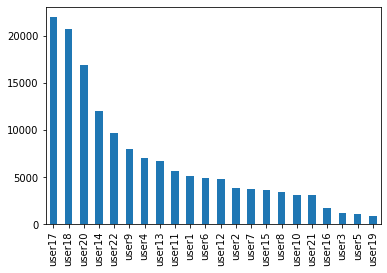

In [96]:
user_data['label'].value_counts().plot.bar()

# make 4th accelearation magnitude feature

In [427]:
user_data['ac_mag']=np.sqrt(user_data['x']*user_data['x']+user_data['y']*user_data['y']+user_data['z']*user_data['z'])

In [428]:
user_data.head()

,time,x,y,z,label,ac_mag
0,0.000000,0.69464,3.17350,7.5048,user1,8.177753
1,0.030639,0.14982,3.48680,9.2755,user1,9.910354
2,0.069763,-0.29965,1.94770,9.1120,user1,9.322654
3,0.099823,-1.68890,1.41650,10.1200,user1,10.357280
4,0.129820,-2.17930,0.95342,10.9240,user1,11.179988


# visualize how different x,y,z and magnitude values behave 

In [418]:
user="user2"
user=user_data[user_data["label"]==user].head(400)
fig = px.line(user, x="time", y="ac_mag", title='time vs ac_mag for user2 ')
fig.show()

In [419]:
user="user2"
user=user_data[user_data["label"]==user].head(400)
fig = px.line(user, x="time", y="x", title='time vs x for user2 ')
fig.show()

In [421]:
user="user2"
user=user_data[user_data["label"]==user].head(400)
fig = px.line(user, x="time", y="y", title='time vs y for user2 ')
fig.show()

In [137]:
user="user4"
user=user_data[user_data["label"]==user].head(400)
fig = px.line(user, x="time", y="ac_mag", title='time vs ac_mag for user4')
fig.show()

# How to bootstrap for a specific user

In [422]:
user="user6"
user=user_data[user_data["label"]==user].head(400)
fig = px.line(user, x="time", y="ac_mag", title='time vs ac_mag for user6')
fig.show()

In [423]:
user="user6"
user=user_data[user_data["label"]==user].head(400).sample(frac=0.3).sort_values(by=['time'])
fig = px.line(user, x="time", y="ac_mag", title='random sample time vs ac_mag for user6')
fig.show()

# Some intution for feature engineering using SPIKE DETECTION

No handles with labels found to put in legend.


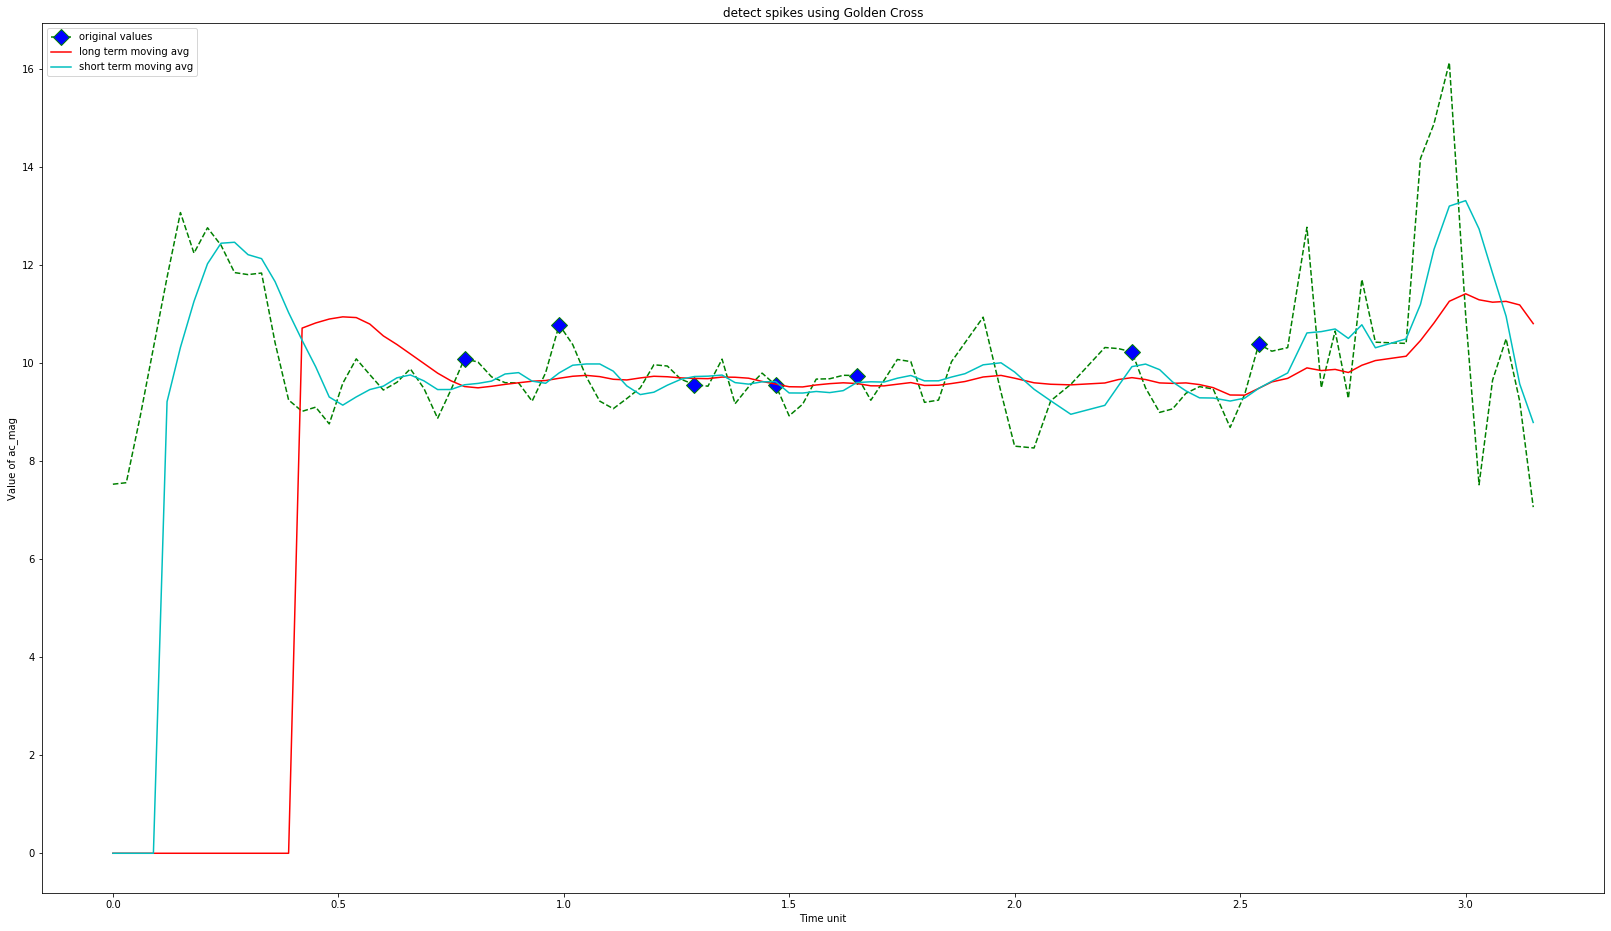

In [395]:
tmp=user_data[user_data["label"]=="user10"]
siz=tmp.shape[0]
i=0
# find fluctuations
col_name="ac_mag"
df=tmp.iloc[0:100]
unique_markers,longterm,shorterm=get_peaks(df,col_name)
len(unique_markers)
# plot magnitude of column
fig = plt.gcf()
fig.set_size_inches(28, 16)
s = list(shorterm.fillna(0).values)
l = list(longterm.fillna(0).values)

xs = df["time"].values.tolist()
ys = df["ac_mag"].values.tolist()
markers_on =unique_markers
plt.plot(xs, ys, '-gD', markevery=markers_on ,markersize=12,markerfacecolor='blue',linestyle='dashed')
# added plots of long and short term moving averages to better visualization. You can play with the moving averages windows to understand better
plt.plot(xs, l, 'r')
plt.plot(xs, s, 'c')
plt.xlabel("Time unit")
plt.ylabel("Value of "+col_name)
plt.title("detect spikes using Golden Cross")
plt.legend()
plt.legend(['original values','long term moving avg','short term moving avg'])
plt.show()

# Feature Development

In [200]:
def get_peaks(df,column_name):
    short_term_lag=5
    long_term_lag=15
    # you can use .mean() instead of explicitly taking the mean
    # df.Sunspots.rolling(short_term_lag).mean()
    shorterm=df[column_name].rolling(short_term_lag).sum()/short_term_lag
    longterm=df[column_name].rolling(long_term_lag).sum()/long_term_lag
    count=0
    markers=[]
    unique_markers=[]
    while(count<longterm.shape[0]):
        if(longterm.iloc[count]<shorterm.iloc[count]):
            markers.append(count)
            if(count-1 not in markers):
                unique_markers.append(count)
        count=count+1
    return unique_markers,longterm,shorterm

In [429]:
def features_single_column(single_user_window_df,column_name,window_size):
    avg_acc=single_user_window_df[column_name].mean()
    var=single_user_window_df[column_name].var()
    unique_markers,longterm,shorterm=get_peaks(single_user_window_df,column_name)
    num_fluct=len(unique_markers)
    max_val=single_user_window_df[column_name].max()
    min_val=single_user_window_df[column_name].min()
    acr=[]
    start=int(window_size*0.3)
    stop=int(window_size*0.7)
    for i in range(start,stop+1):
        acr.append(single_user_window_df[column_name].autocorr(lag=i))
    acr=np.array(acr)
    acr_max=acr.max()
    acr_min=acr.min()
    acr_avg=acr.mean()
    acr_var=acr.var()
    features={"avg_"+column_name:avg_acc,
             "var_"+column_name:var,
             "num_fluct_"+column_name:num_fluct,
             "max_"+column_name:max_val,
             "min_"+column_name:min_val,
             "atcr_max_"+column_name:acr_max,
             "atcr_min_"+column_name:acr_min,
             "atcr_avg_"+column_name:acr_avg,
             "atcr_var_"+column_name:acr_var}
    return features
    
        
        
    
    
    
    

In [430]:
def features_single_window(single_user_window_df,label,window_size):
    avg_time_diff=single_user_window_df["time"].diff().mean()
    features={"avg_time_diff":avg_time_diff}
    cols=["x","y","z","ac_mag"]
    for column_name in cols:
        features.update(features_single_column(single_user_window_df,column_name,window_size))
    features["label"]=label
    return features
    
        

In [431]:
def get_features(user_data,window_size):
    data=[]
    for j in range(1,23):
        label="user"+str(j)
        single_user_data=user_data[user_data["label"]==label]
        siz=single_user_data.shape[0]
        i=0
        count=0
        print(j," th user")
        while(i<siz):
            data.append(features_single_window(single_user_data.iloc[i:i+window_size],label,window_size))
            i=i+window_size
    return data

In [432]:
data=get_features(user_data,150)

1  th user
2  th user
3  th user


//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning:

Degrees of freedom <= 0 for slice

//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning:

divide by zero encountered in true_divide



4  th user
5  th user
6  th user
7  th user
8  th user
9  th user
10  th user
11  th user
12  th user
13  th user
14  th user
15  th user
16  th user
17  th user
18  th user
19  th user
20  th user
21  th user
22  th user


# Create Training Data

In [433]:
df = pd.DataFrame(data) 

In [443]:
df.describe()

,atcr_avg_ac_mag,atcr_avg_x,atcr_avg_y,atcr_avg_z,atcr_max_ac_mag,atcr_max_x,atcr_max_y,atcr_max_z,atcr_min_ac_mag,atcr_min_x,...,min_y,min_z,num_fluct_ac_mag,num_fluct_x,num_fluct_y,num_fluct_z,var_ac_mag,var_x,var_y,var_z
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,...,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000
mean,-0.008377,-0.012737,-0.012469,-0.010242,0.704556,0.638408,0.690372,0.611780,-0.591516,-0.438836,...,4.418707,-3.824466,8.616785,8.708797,8.256825,8.790698,6.325858,3.694326,5.719007,3.579824
std,0.031778,0.079209,0.064793,0.088303,0.236232,0.225345,0.251334,0.231868,0.191727,0.142793,...,2.611468,2.951682,1.856099,1.657437,1.561417,2.069069,5.052767,4.742496,4.248779,4.681265
min,-0.360756,-0.618298,-0.607689,-0.679874,0.131712,-0.233127,-0.461143,-0.356565,-0.962072,-0.903746,...,-10.924000,-14.982000,6.000000,3.000000,4.000000,4.000000,0.001383,0.001176,0.001655,0.001826
25%,-0.029052,-0.032628,-0.033304,-0.027082,0.488025,0.467682,0.485683,0.435798,-0.752098,-0.516190,...,3.568500,-5.516200,8.000000,8.000000,7.000000,7.000000,2.959809,1.453105,3.036845,1.497301
50%,-0.008232,-0.013287,-0.010898,-0.010640,0.787674,0.654376,0.777020,0.640017,-0.605363,-0.418318,...,4.712600,-4.290400,8.000000,8.000000,8.000000,8.000000,5.167430,2.465947,4.916522,2.252549
75%,0.008402,0.012283,0.011625,0.009213,0.916389,0.841229,0.909970,0.811925,-0.437453,-0.342639,...,5.979300,-2.683200,9.000000,10.000000,9.000000,10.000000,8.625786,4.794560,7.851632,3.551938
max,0.067450,0.513389,0.408012,0.602109,1.000000,1.000000,1.000000,1.000000,-0.167937,0.174123,...,9.302700,7.273300,18.000000,15.000000,16.000000,20.000000,27.455652,68.663622,27.234784,43.215645


# Calculate total null values and drop NA rows

In [290]:
sum(map(any, df.isnull()))

38

In [438]:
df=df.dropna()

In [444]:
df.shape

(989, 38)

In [445]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [446]:
train.columns

Index(['atcr_avg_ac_mag', 'atcr_avg_x', 'atcr_avg_y', 'atcr_avg_z',
       'atcr_max_ac_mag', 'atcr_max_x', 'atcr_max_y', 'atcr_max_z',
       'atcr_min_ac_mag', 'atcr_min_x', 'atcr_min_y', 'atcr_min_z',
       'atcr_var_ac_mag', 'atcr_var_x', 'atcr_var_y', 'atcr_var_z',
       'avg_ac_mag', 'avg_time_diff', 'avg_x', 'avg_y', 'avg_z', 'label',
       'max_ac_mag', 'max_x', 'max_y', 'max_z', 'min_ac_mag', 'min_x', 'min_y',
       'min_z', 'num_fluct_ac_mag', 'num_fluct_x', 'num_fluct_y',
       'num_fluct_z', 'var_ac_mag', 'var_x', 'var_y', 'var_z'],
      dtype='object')

# Prepare X_train, X_test,y_train,y_test

In [447]:
X_train = train.loc[ : , train.columns != 'label']
y_train = train.loc[ : , train.columns == 'label']
X_test = test.loc[ : , test.columns != 'label']
y_test = test.loc[ : , test.columns == 'label']

# normalization vs standardization

Plotting for column atcr_avg_ac_mag


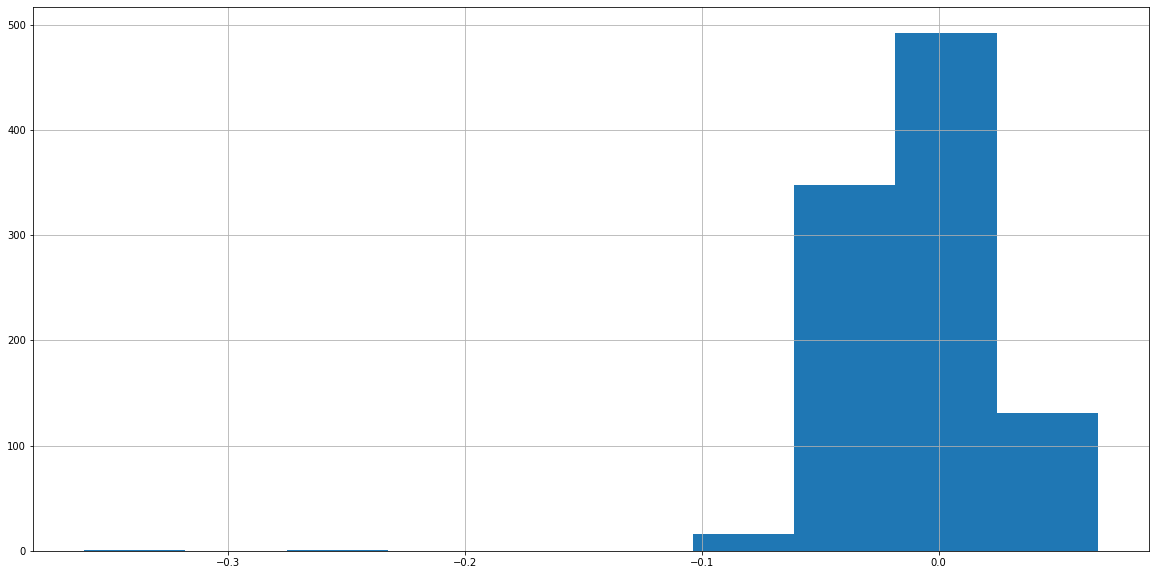

Plotting for column atcr_avg_x


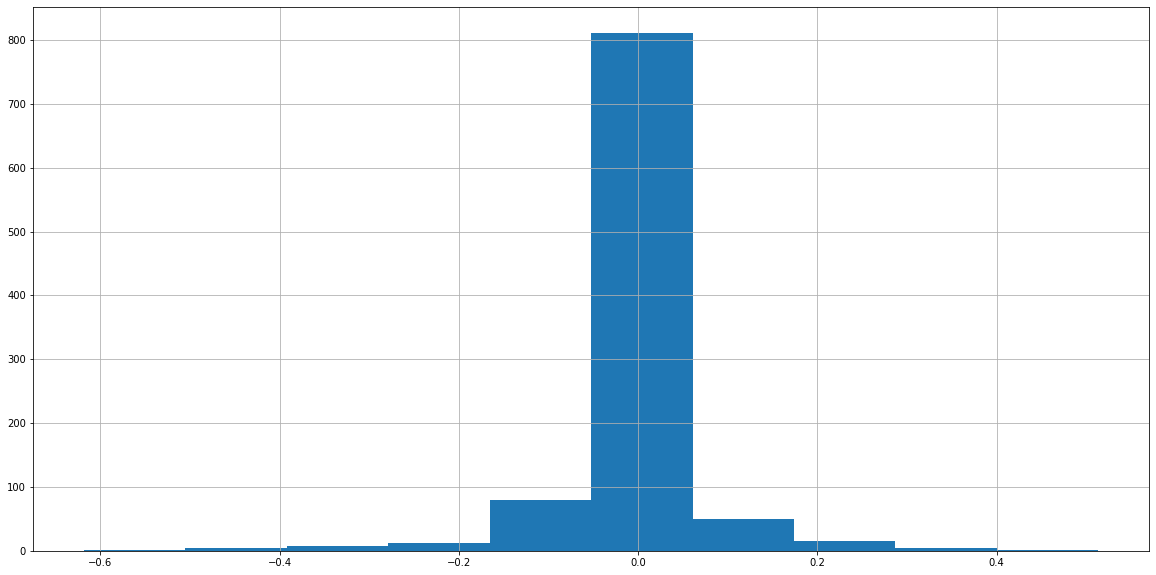

Plotting for column atcr_avg_y


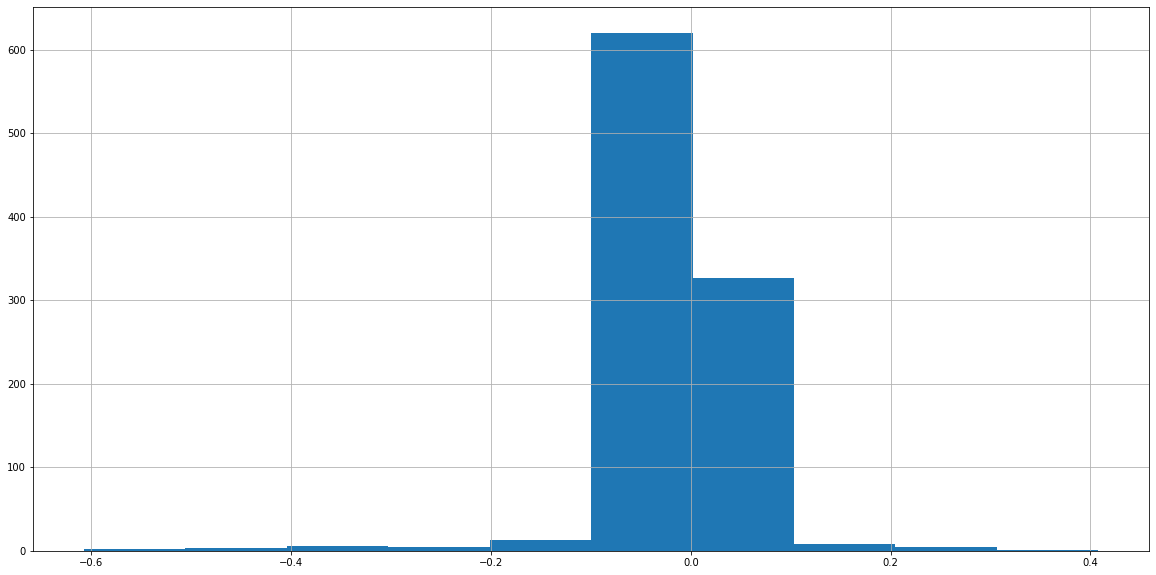

Plotting for column atcr_avg_z


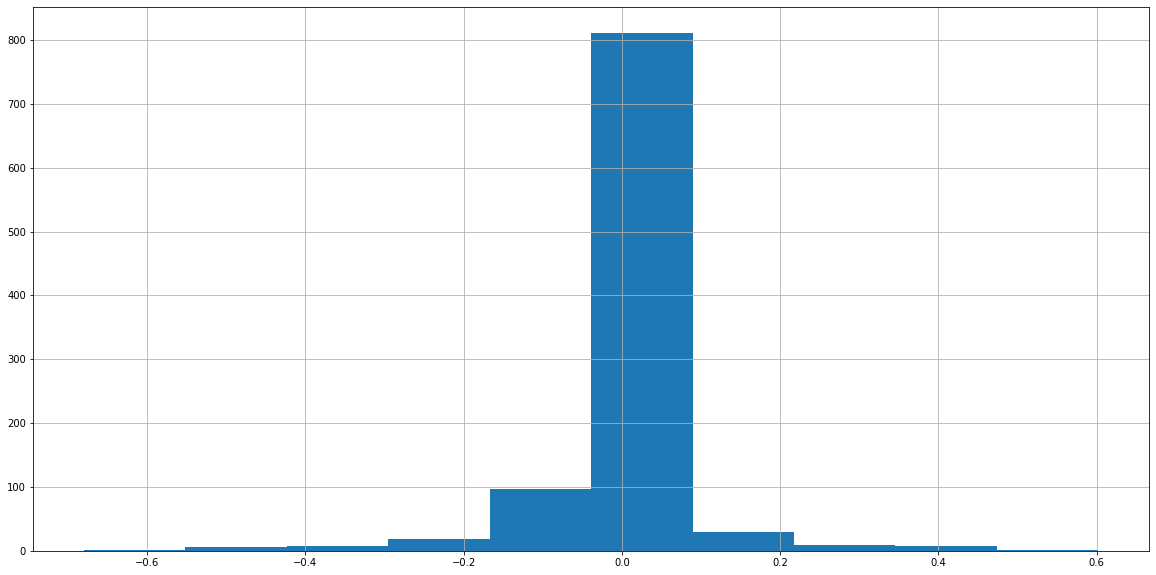

Plotting for column atcr_max_ac_mag


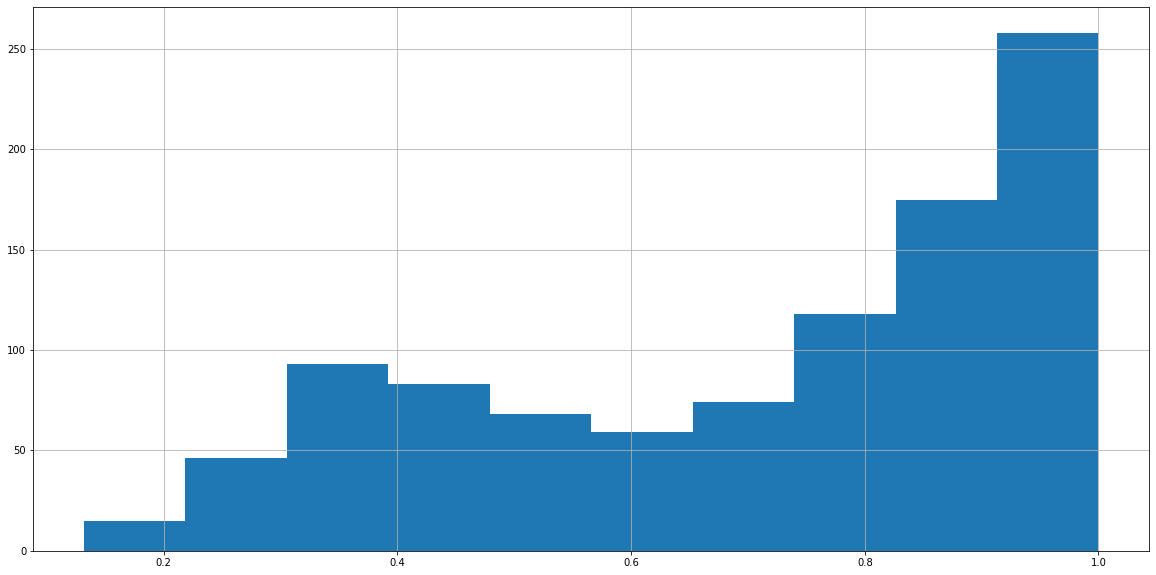

Plotting for column atcr_max_x


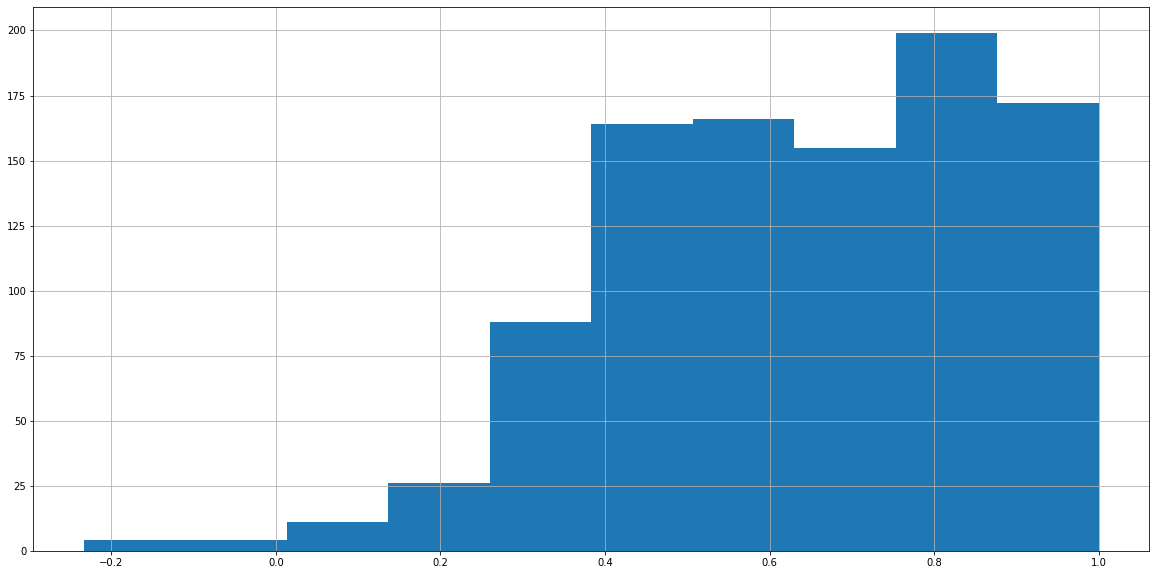

Plotting for column atcr_max_y


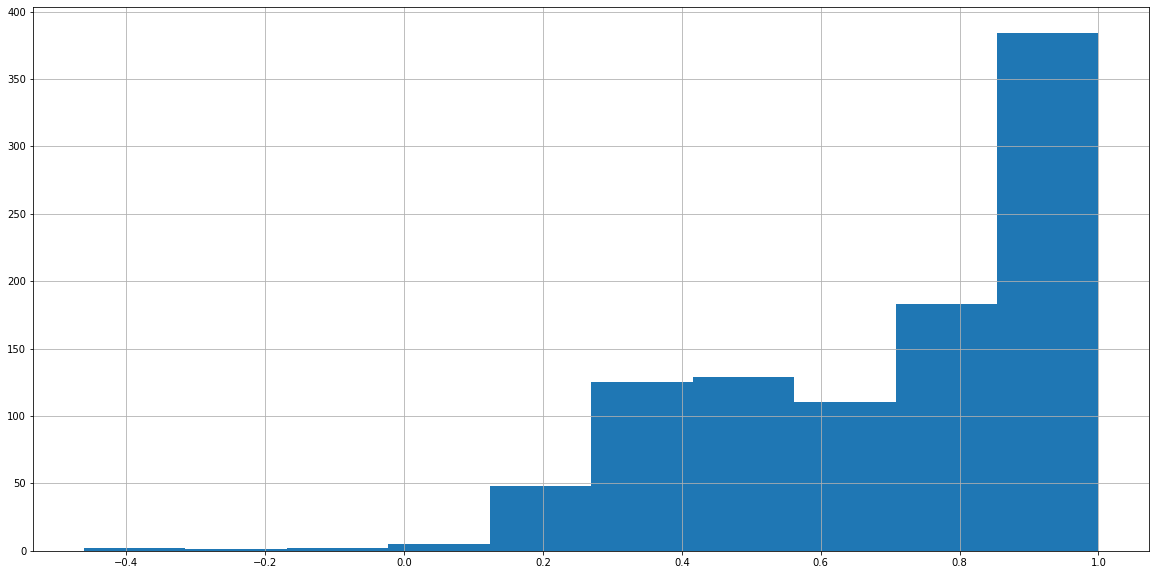

Plotting for column atcr_max_z


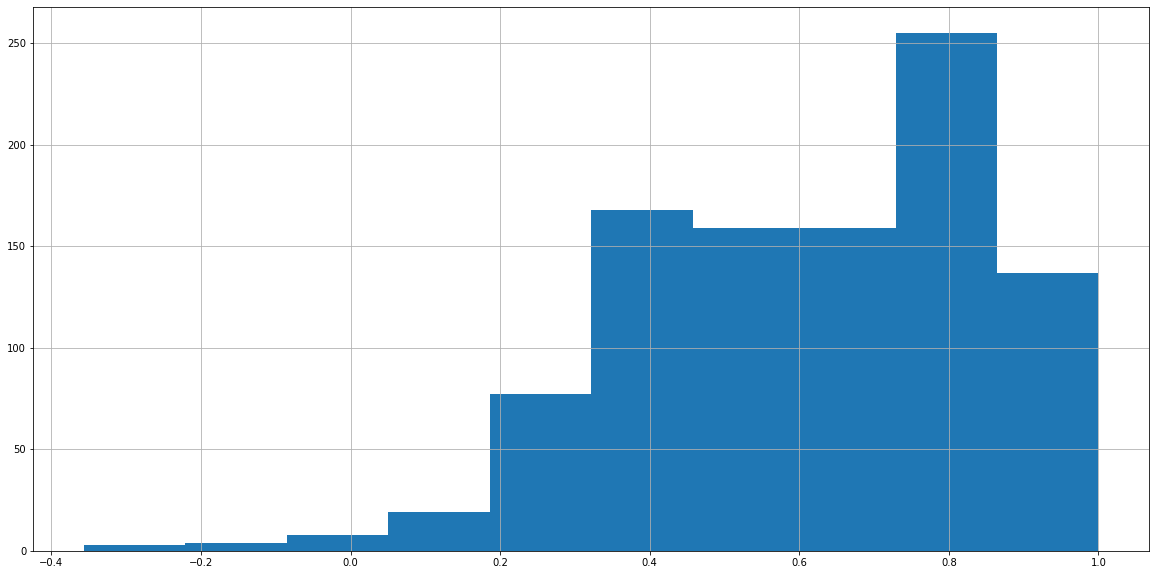

Plotting for column atcr_min_ac_mag


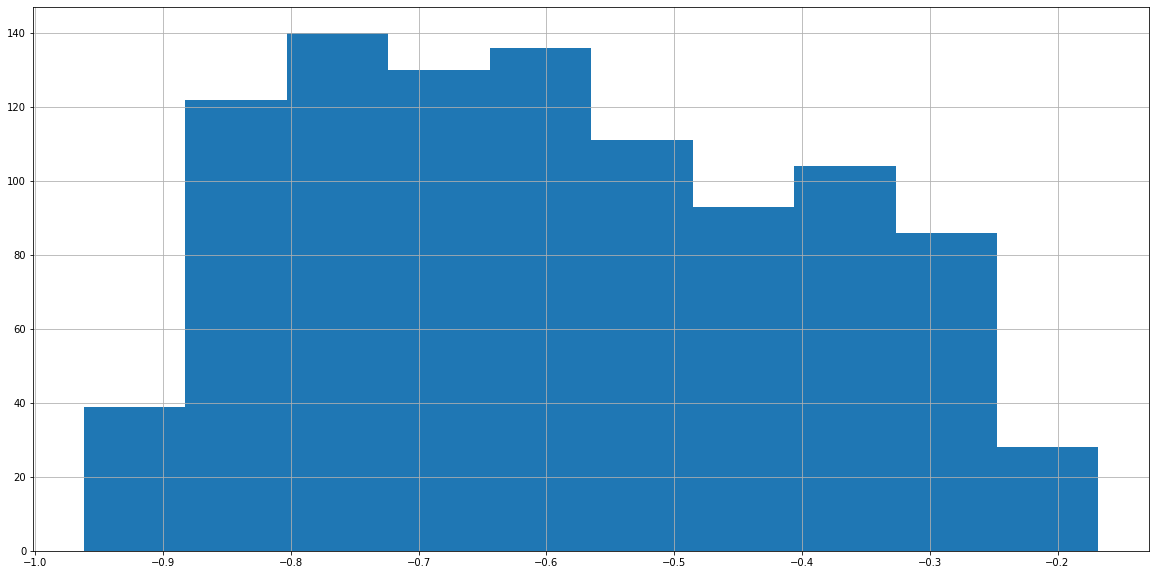

Plotting for column atcr_min_x


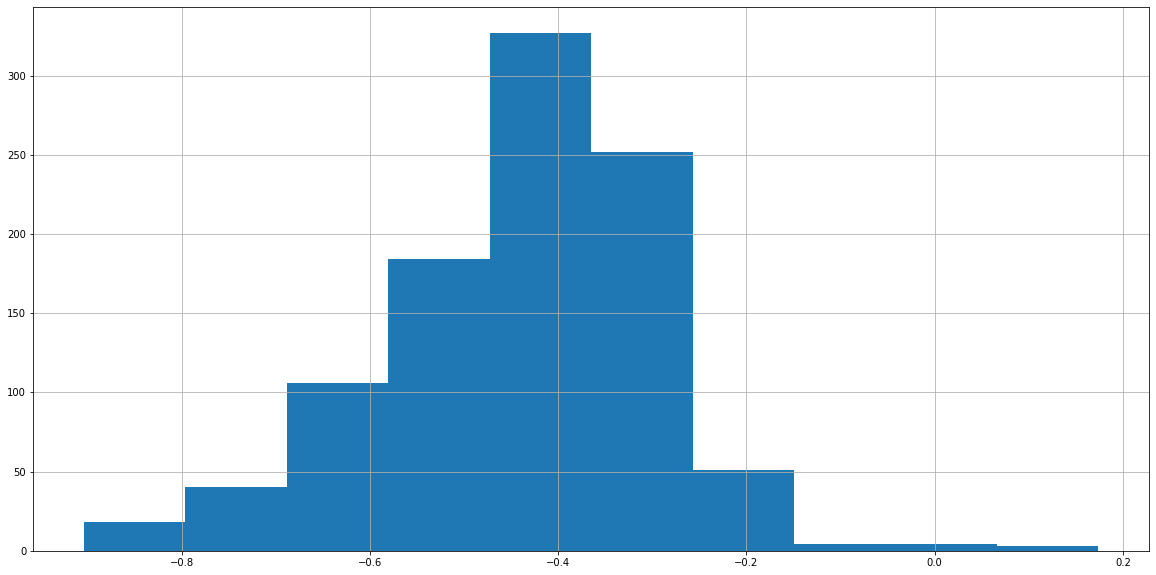

Plotting for column atcr_min_y


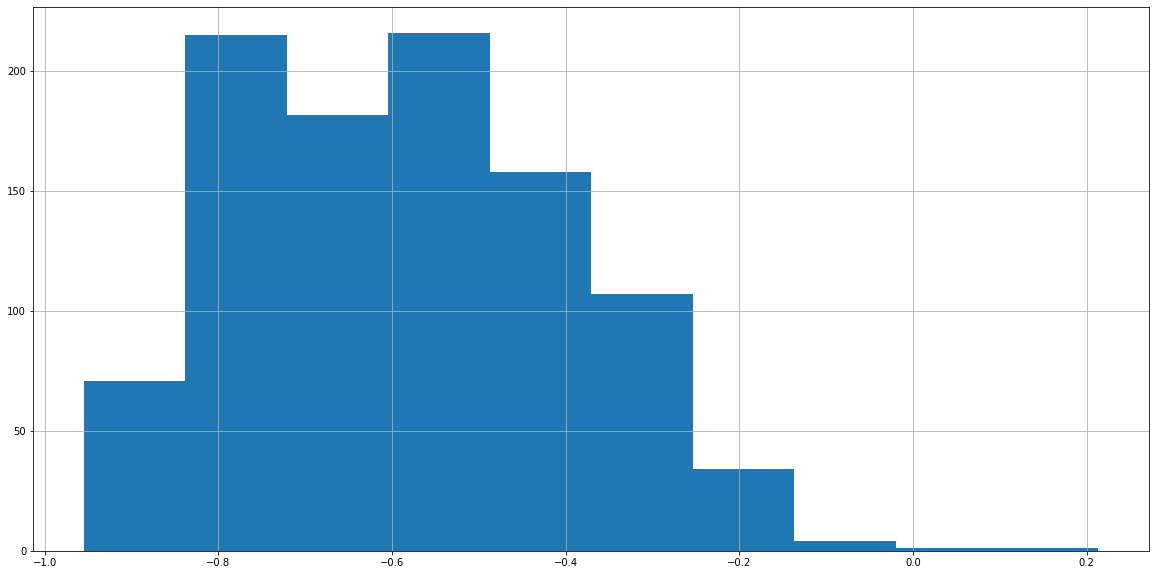

Plotting for column atcr_min_z


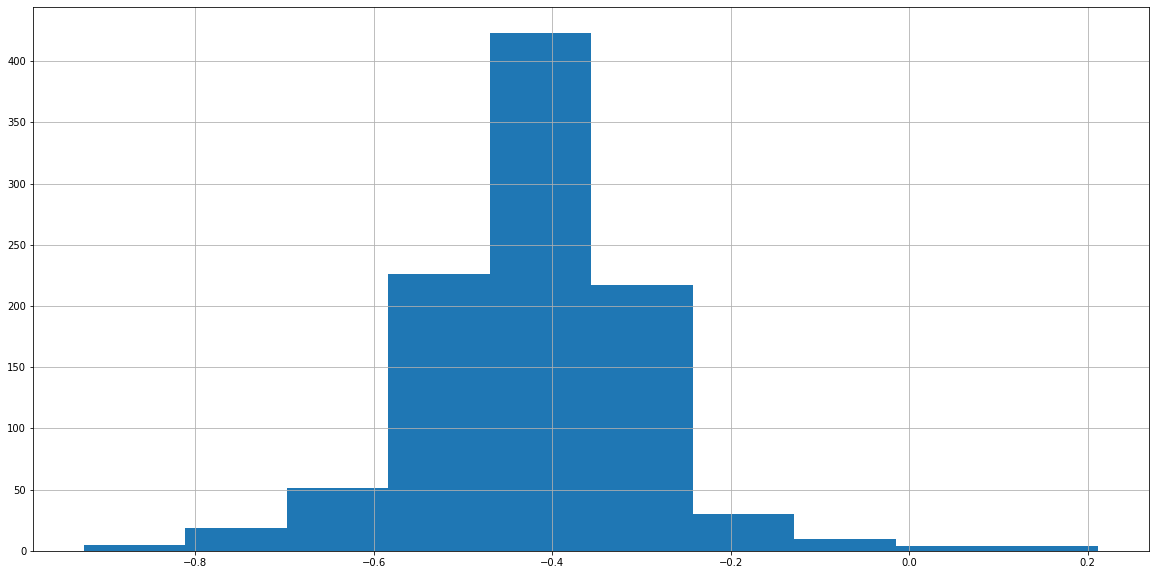

Plotting for column atcr_var_ac_mag


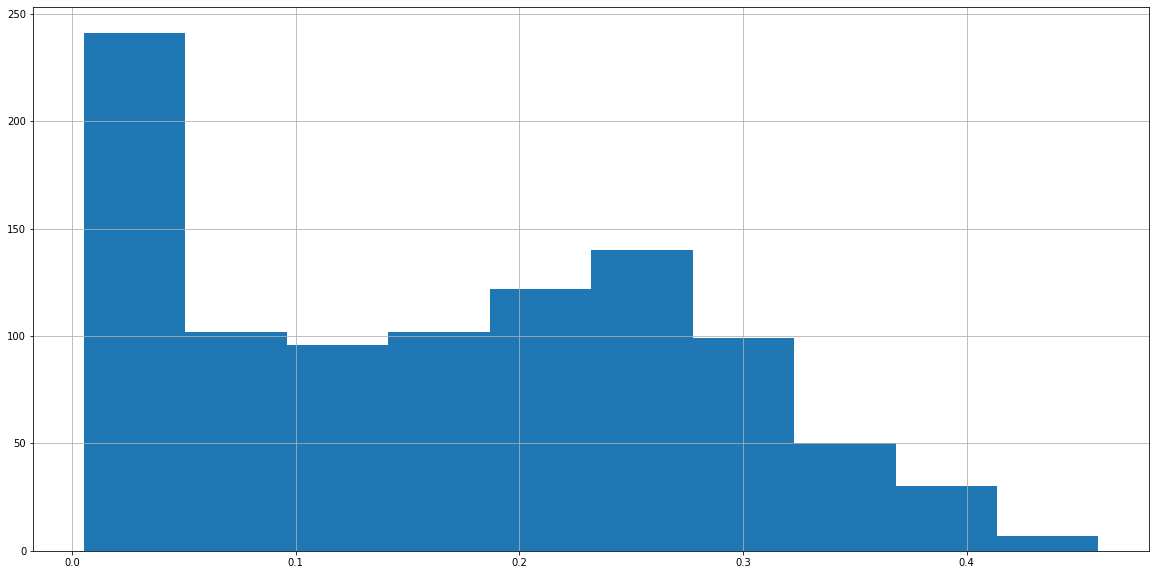

Plotting for column atcr_var_x


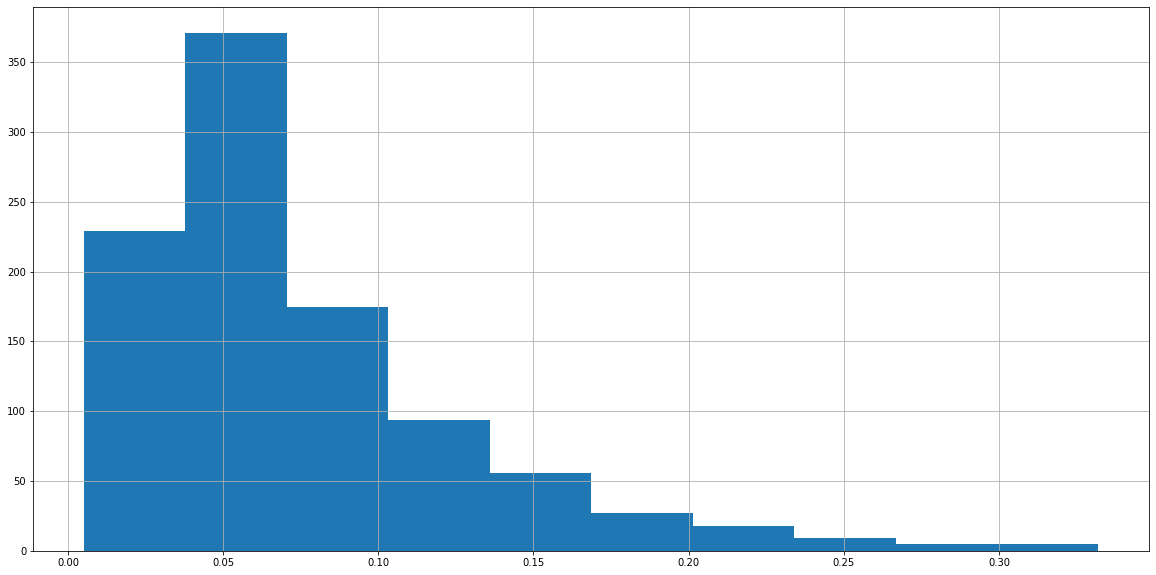

Plotting for column atcr_var_y


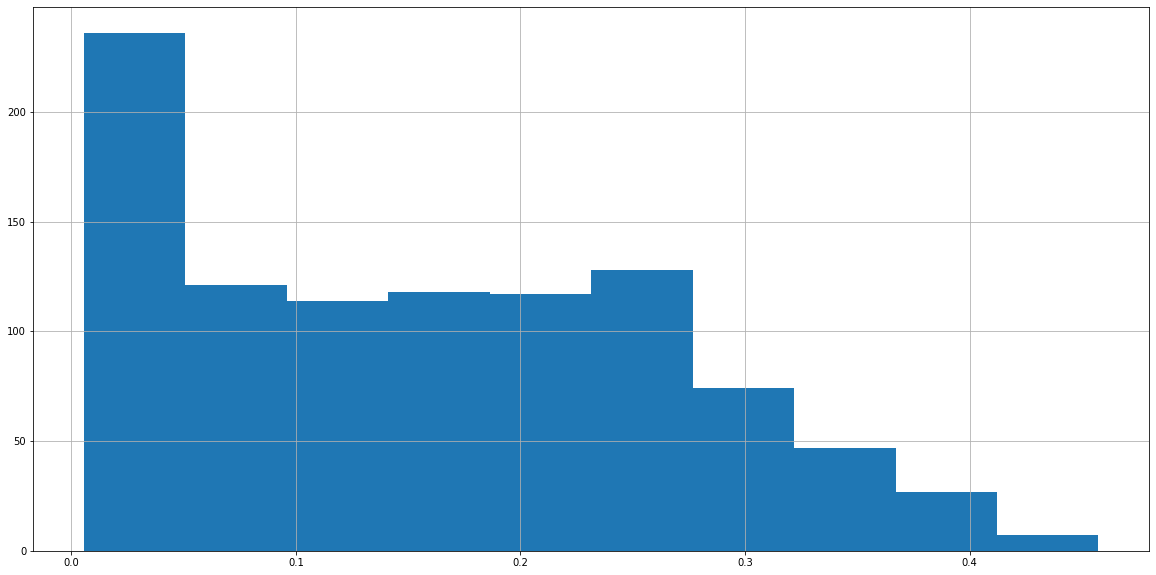

Plotting for column atcr_var_z


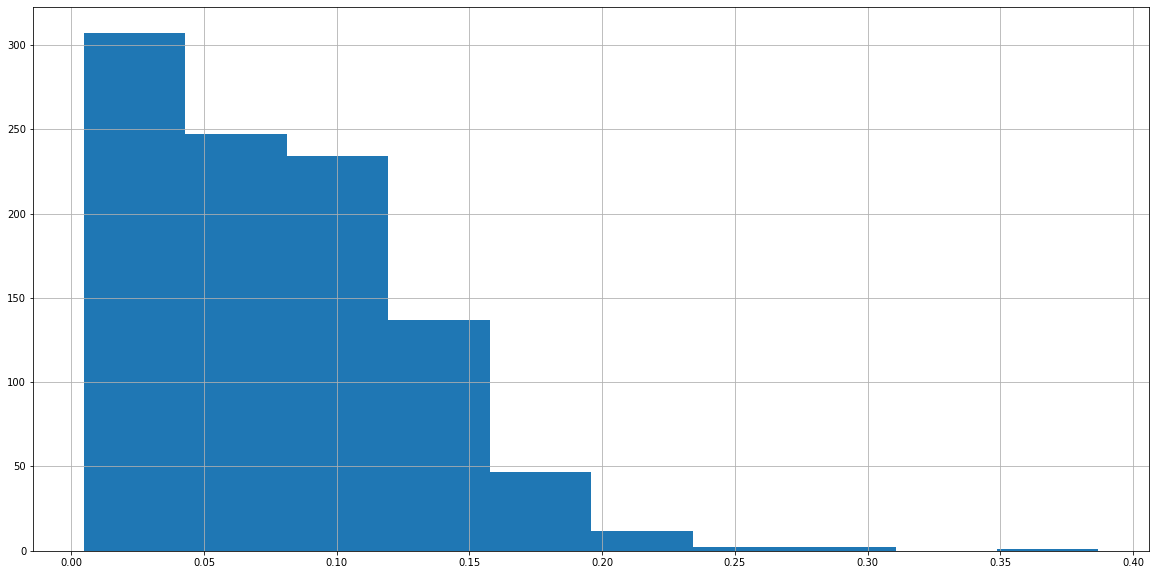

Plotting for column avg_ac_mag


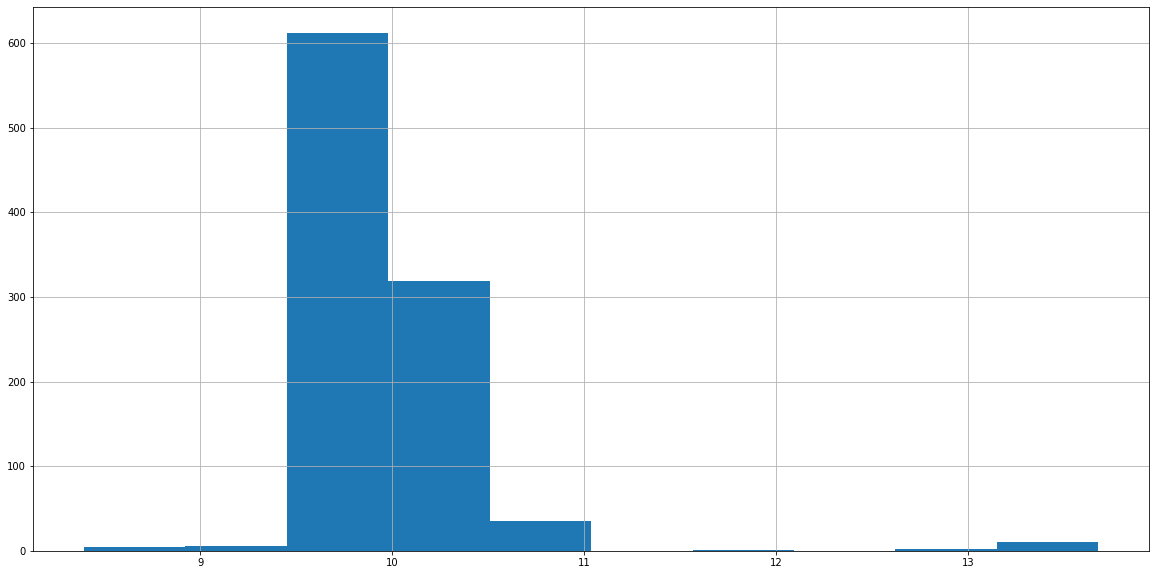

Plotting for column avg_time_diff


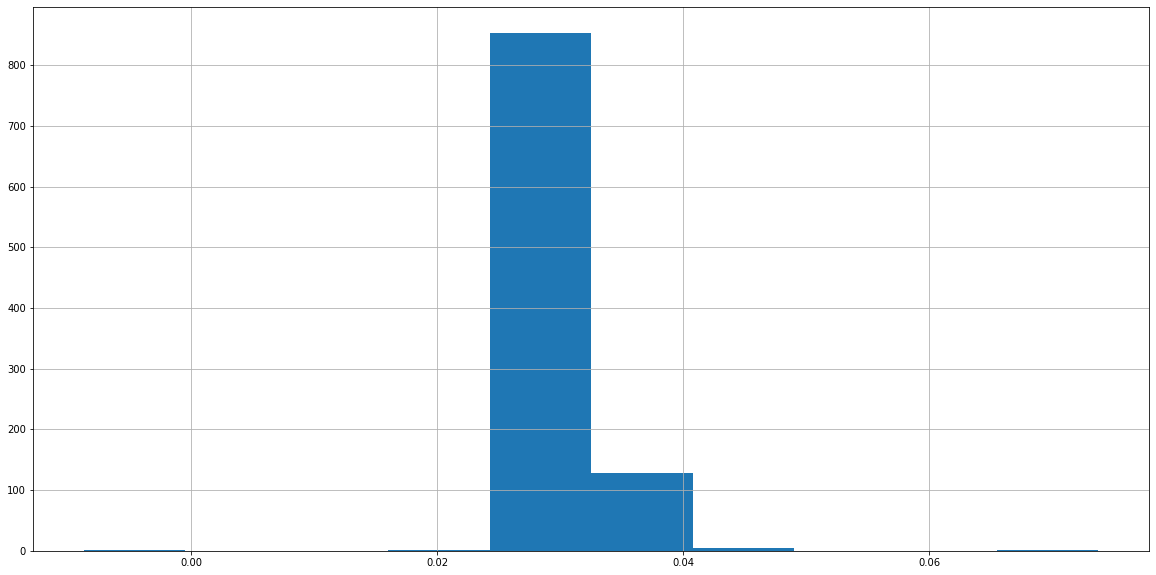

Plotting for column avg_x


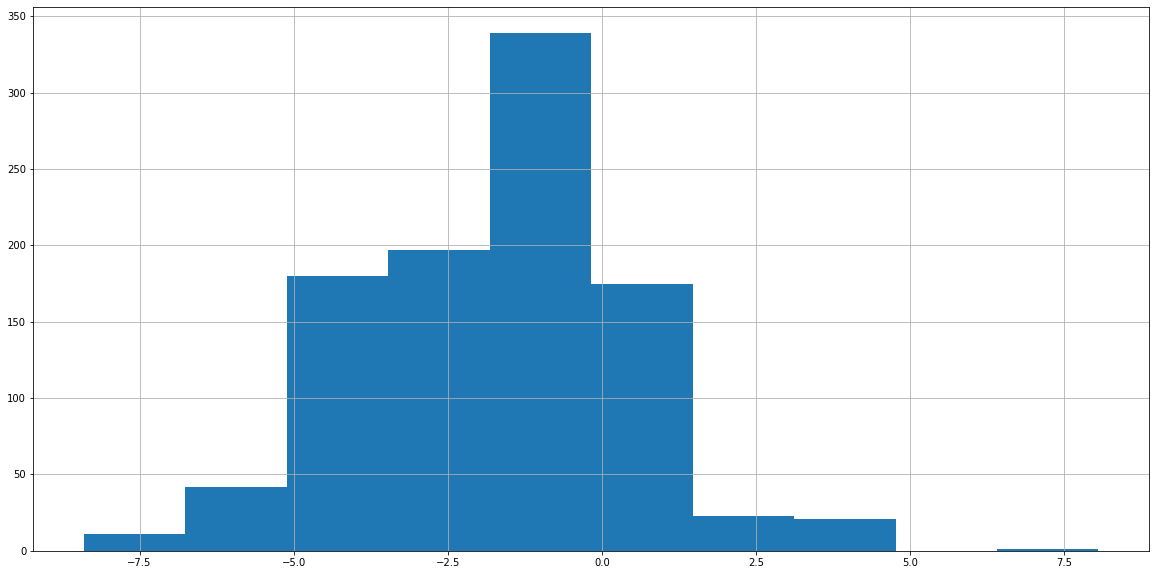

Plotting for column avg_y


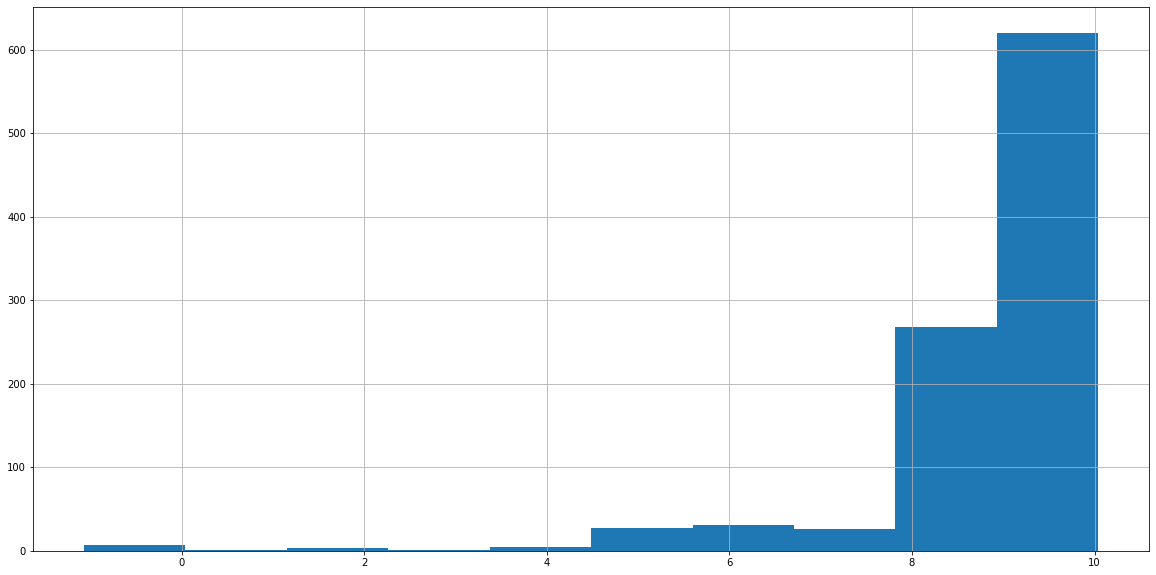

Plotting for column avg_z


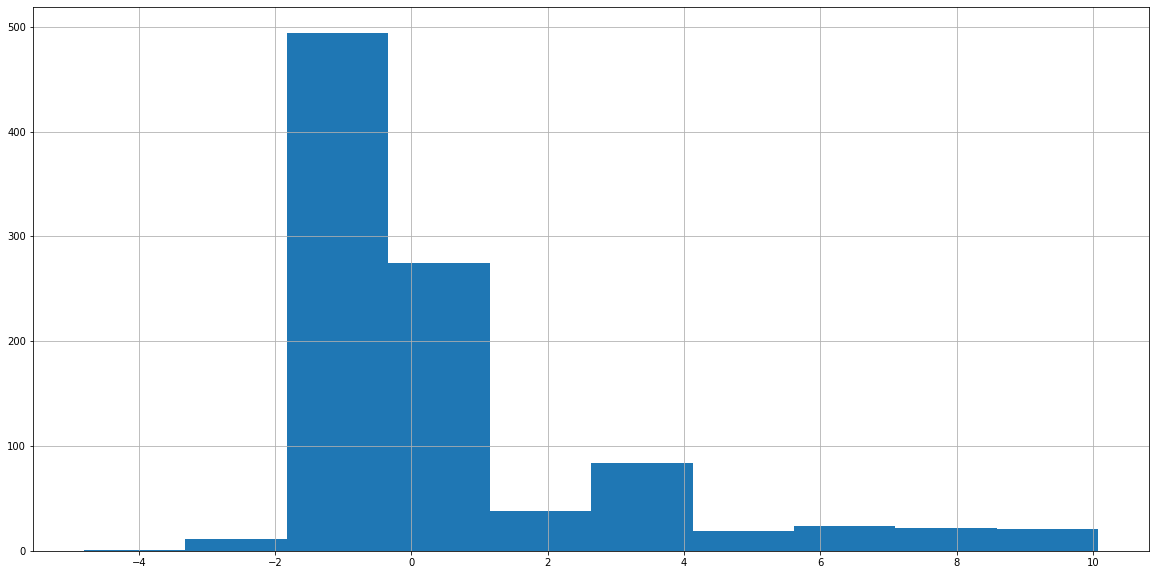

Plotting for column max_ac_mag


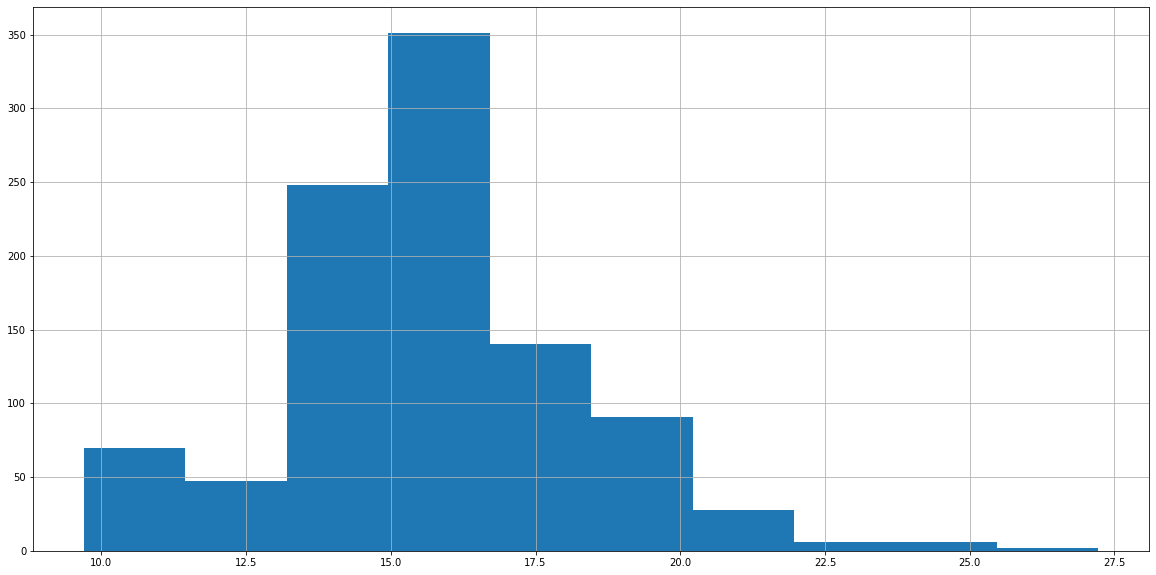

Plotting for column max_x


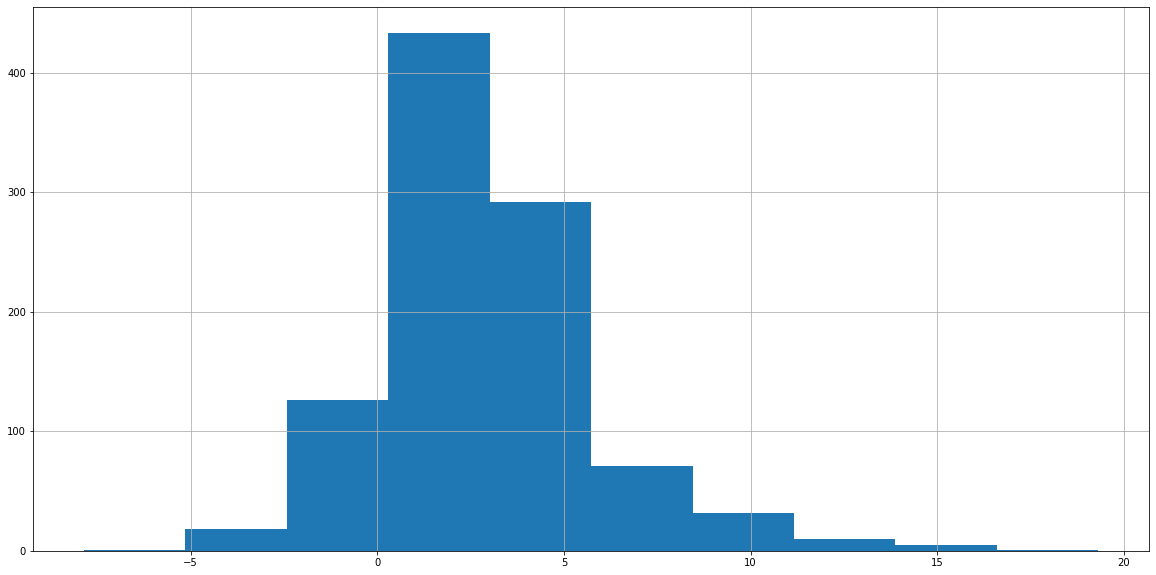

Plotting for column max_y


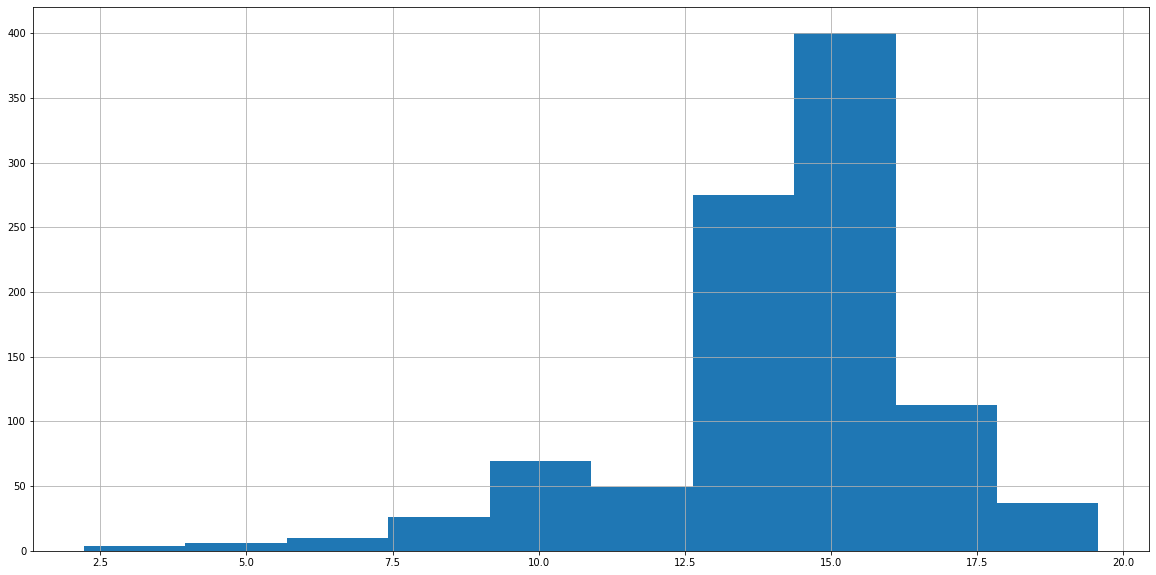

Plotting for column max_z


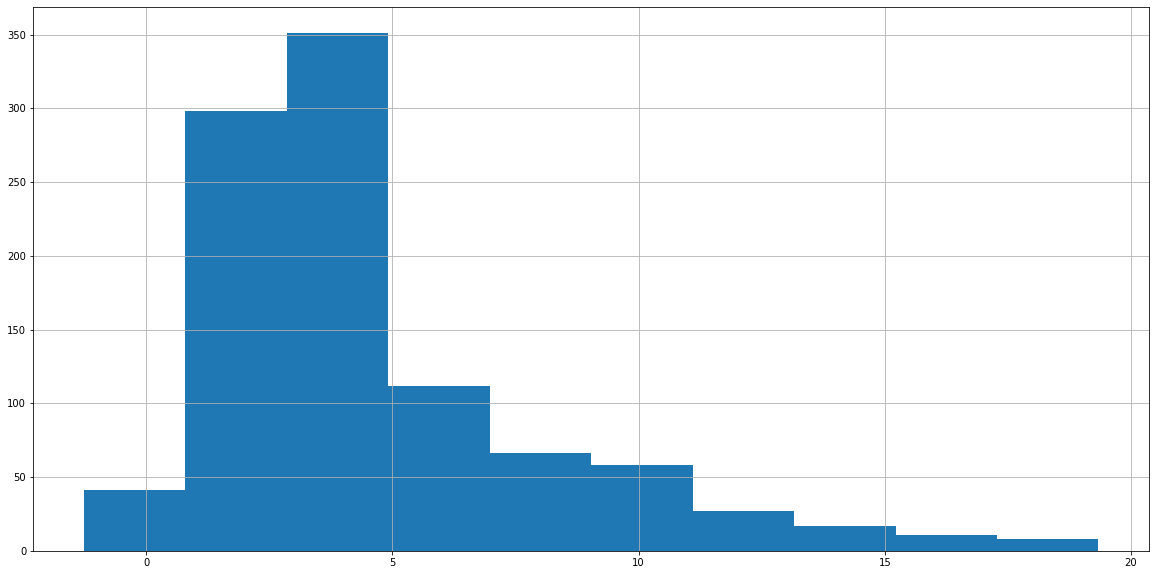

Plotting for column min_ac_mag


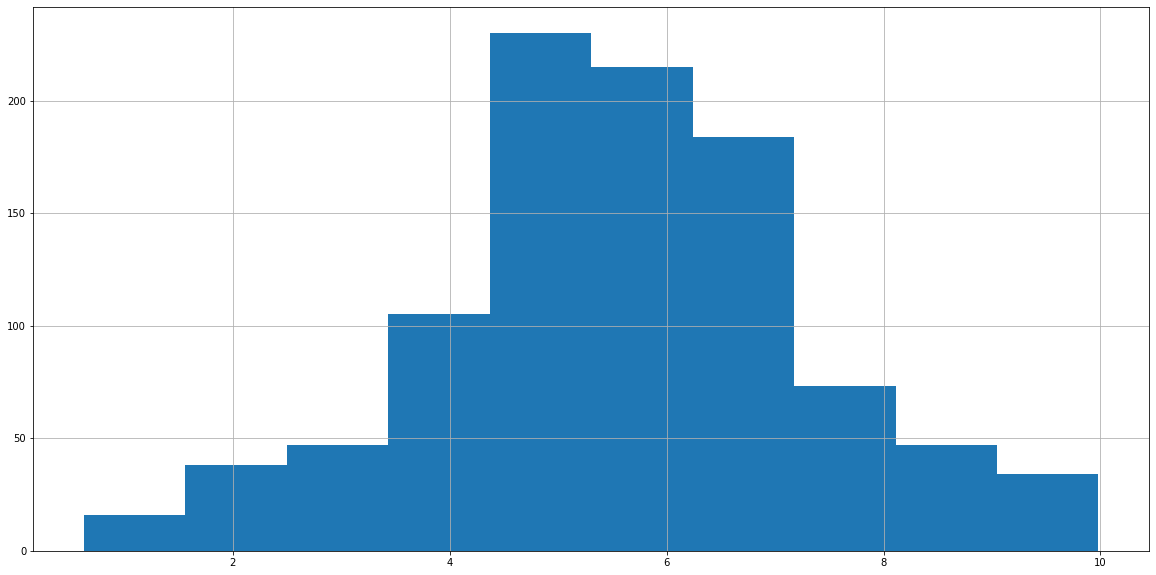

Plotting for column min_x


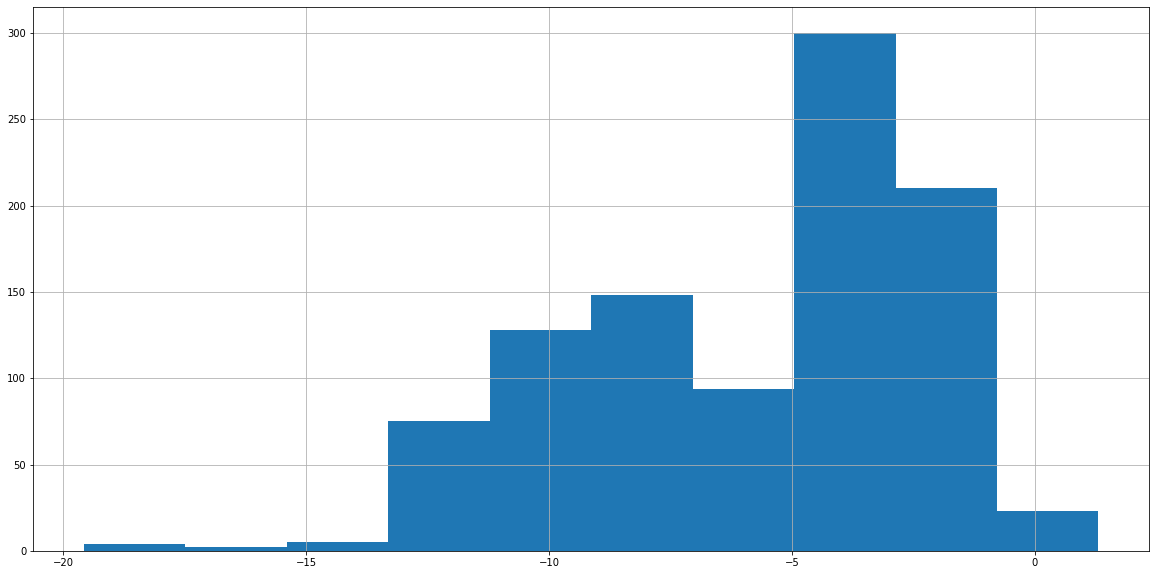

Plotting for column min_y


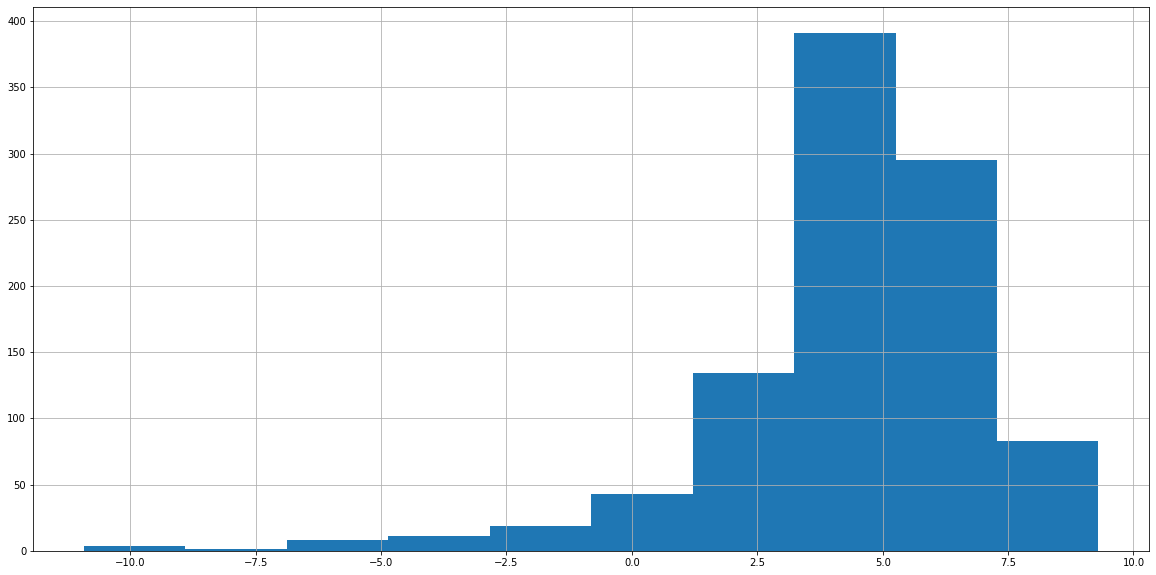

Plotting for column min_z


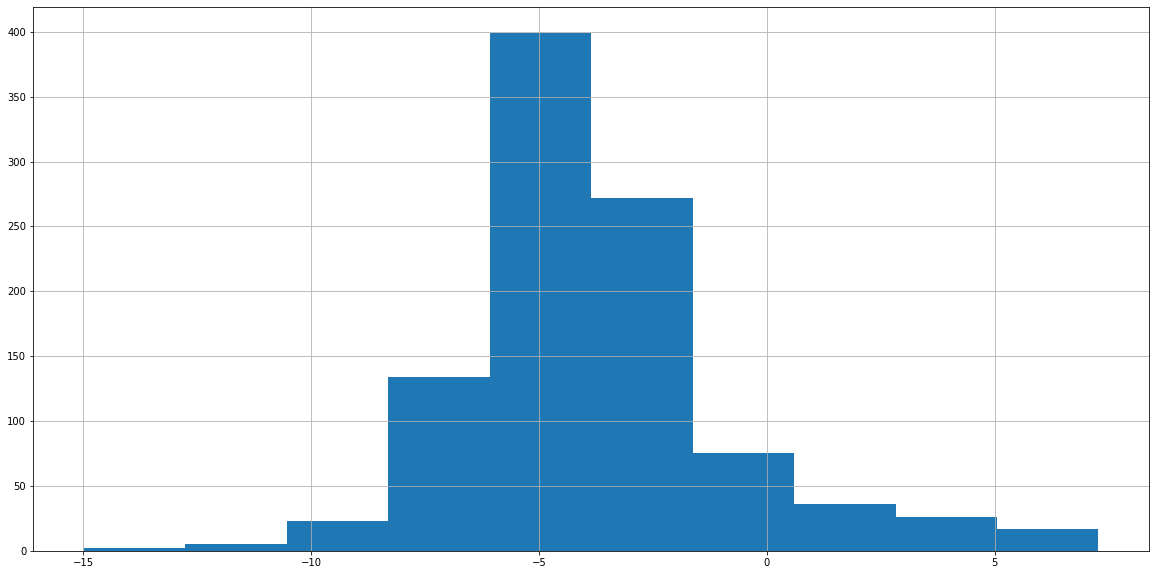

Plotting for column num_fluct_ac_mag


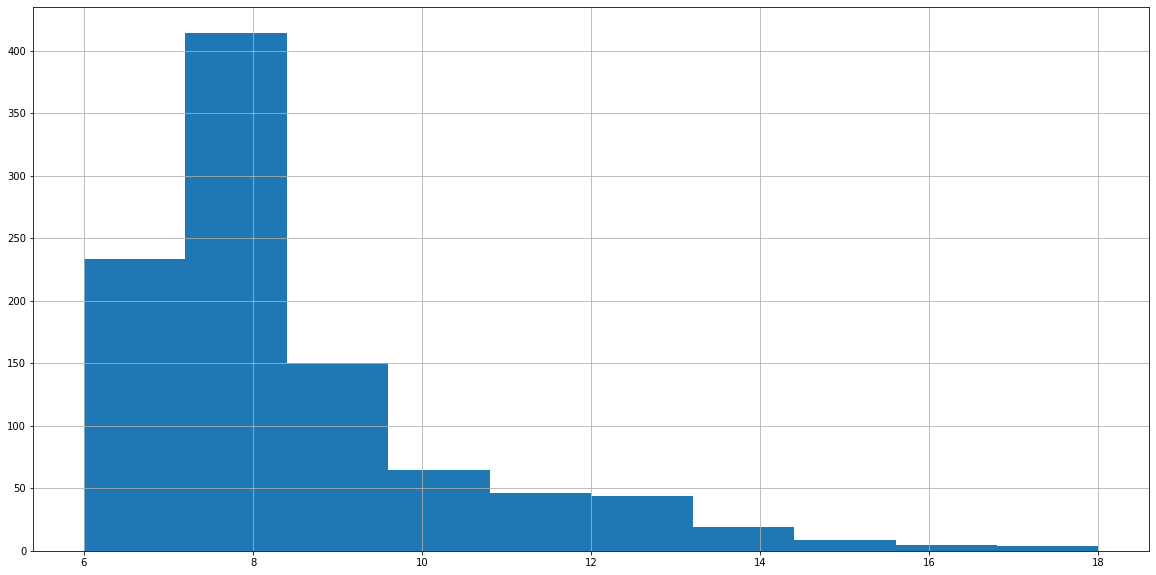

Plotting for column num_fluct_x


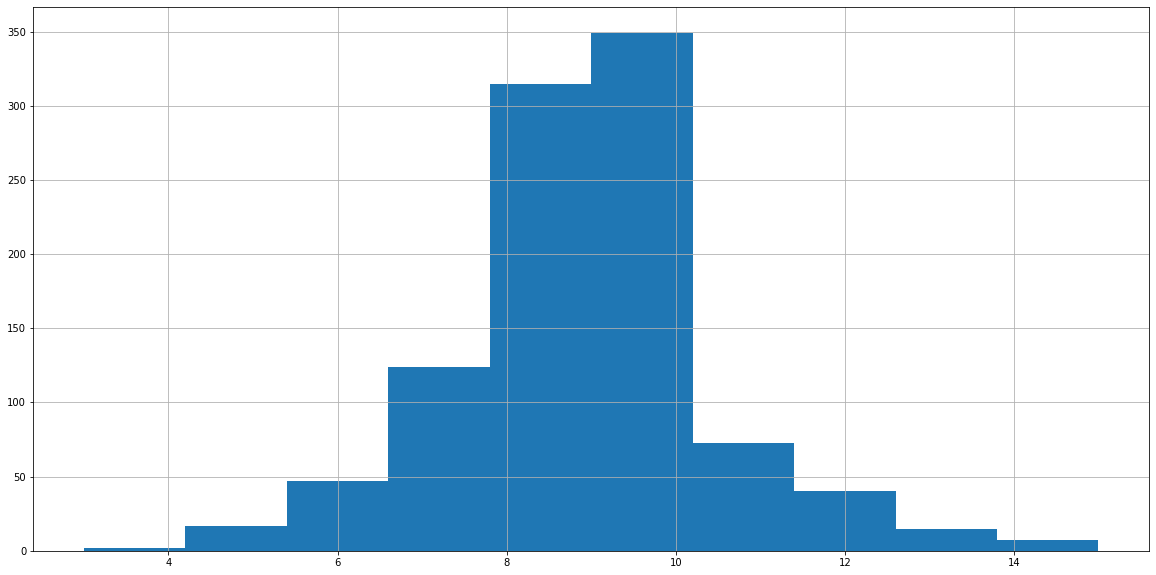

Plotting for column num_fluct_y


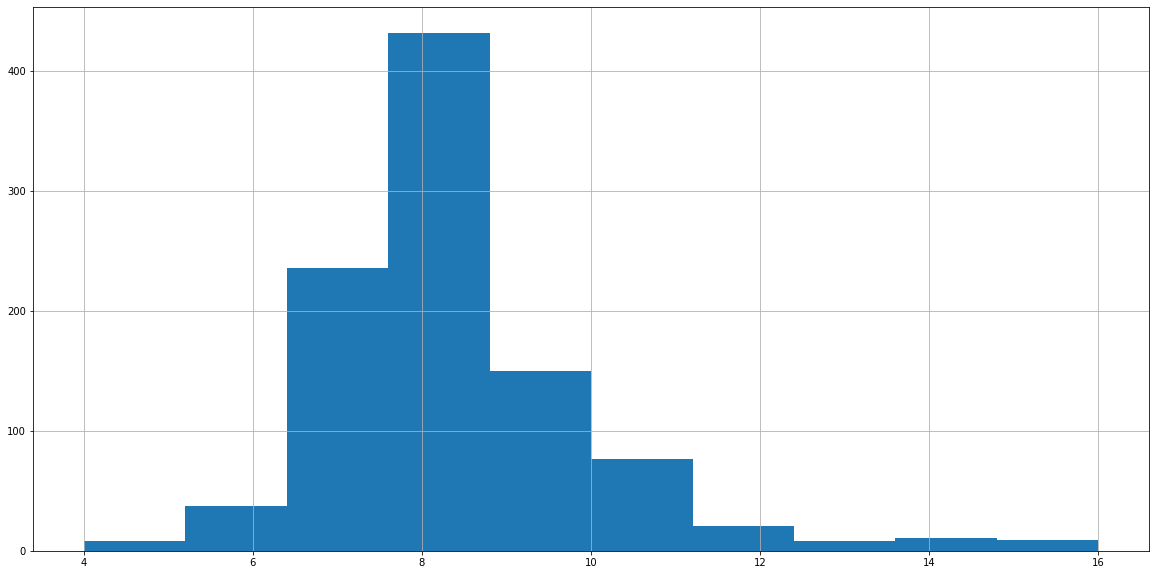

Plotting for column num_fluct_z


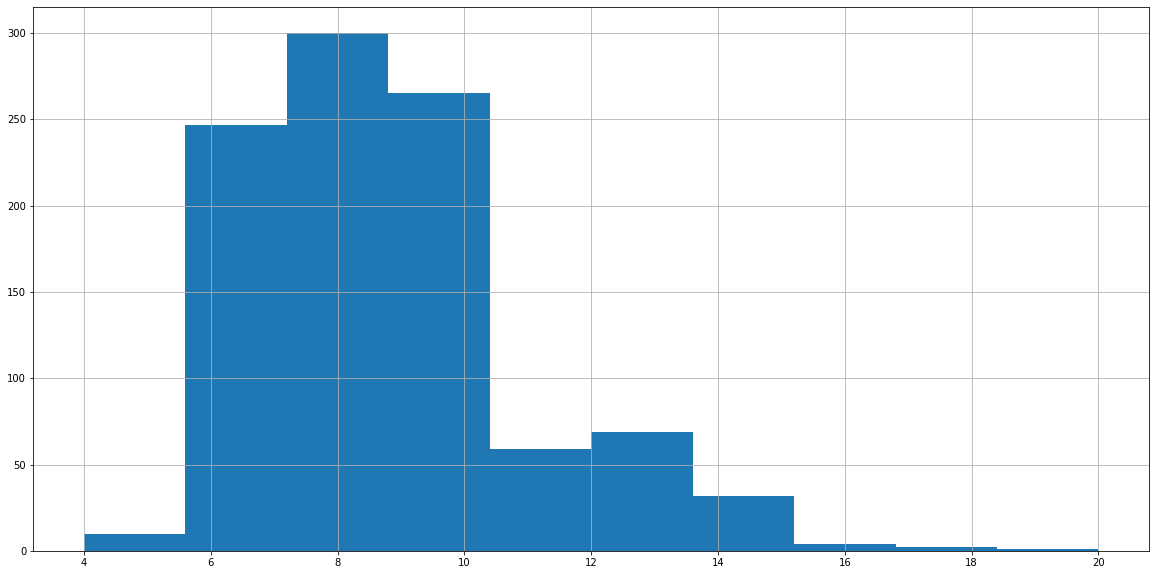

Plotting for column var_ac_mag


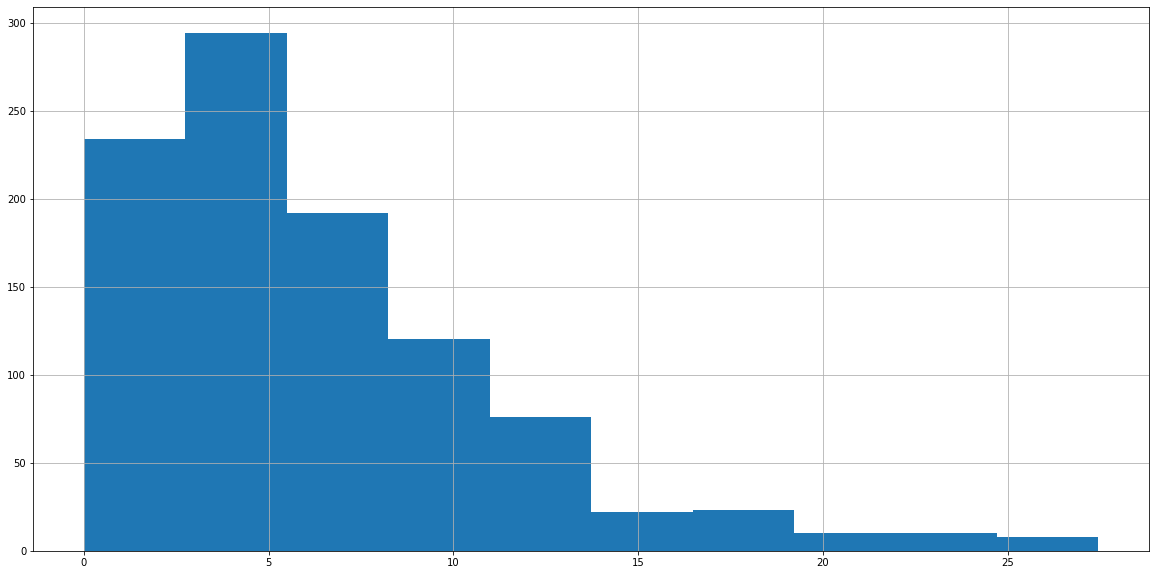

Plotting for column var_x


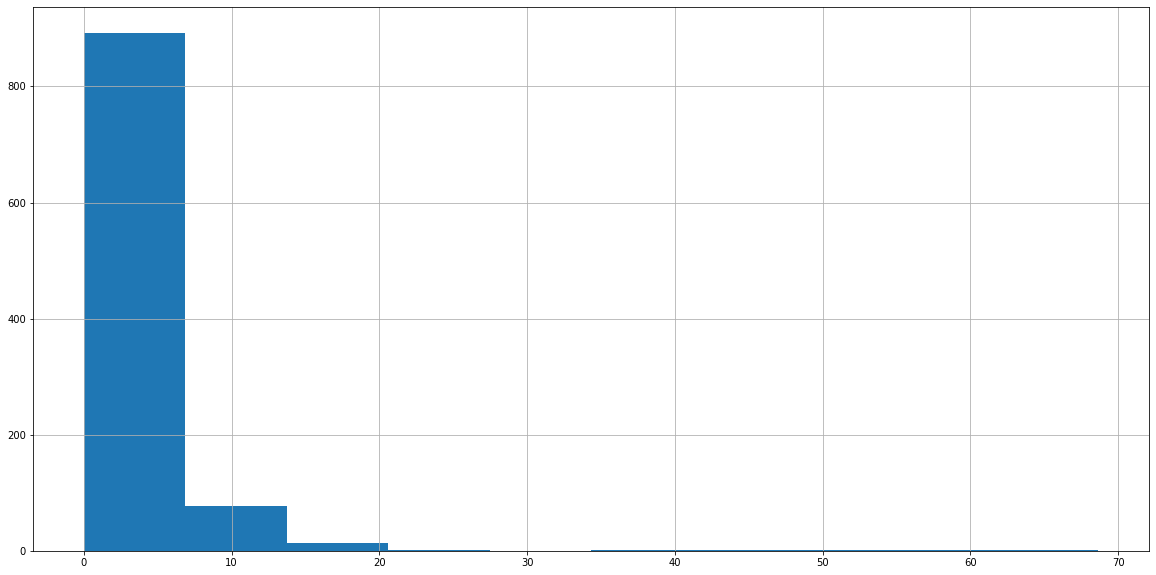

Plotting for column var_y


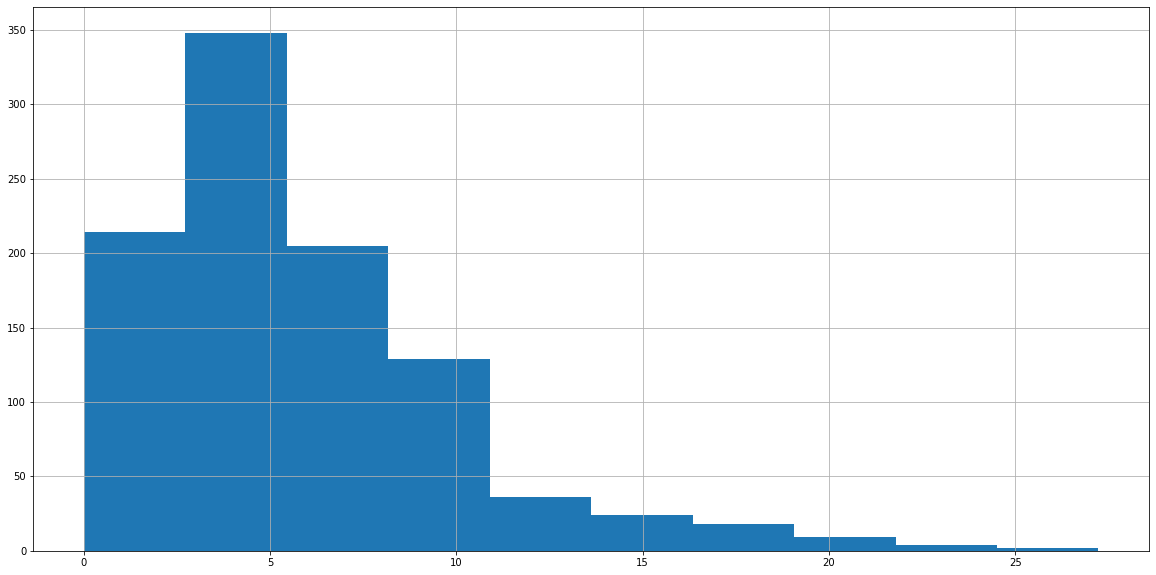

Plotting for column var_z


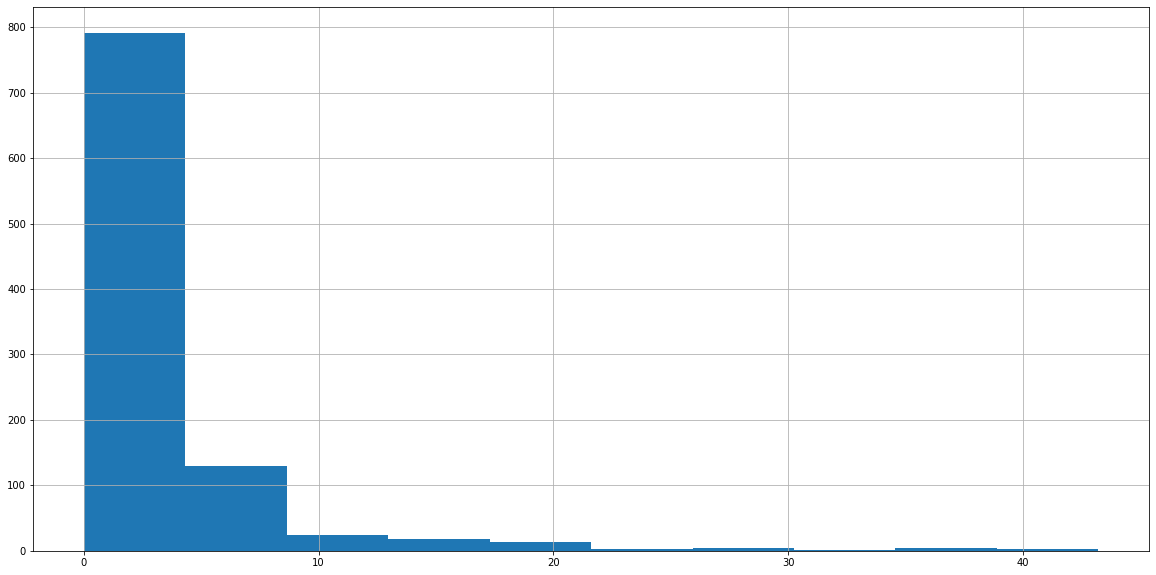

In [448]:
for col in df.columns:
    if(col!="label"):
        hist = df[col].hist(bins=10)
        print("Plotting for column {}".format(col))
        plt.show()

In [389]:
feature_selection.mutual_info_classif(X_train, y_train.values.ravel())
train.loc[ : , train.columns != 'label'].corr()

array([0.21114272, 0.14821188, 0.1973847 , 0.14605258, 0.06564832,
       0.06997025, 0.05881616, 0.10488295, 0.30283193, 0.14391025,
       0.21790043, 0.05284657, 0.22196016, 0.2515301 , 0.24470312,
       0.18950291, 0.44382762, 0.19151551, 1.17005741, 0.87984612,
       0.8485061 , 0.46457976, 0.59269049, 0.42063293, 0.52967509,
       0.35912107, 0.79484466, 0.48690036, 0.53535927, 0.07563305,
       0.12718699, 0.11214846, 0.22171644, 0.49929554, 0.62011525,
       0.46175073, 0.31536513])

In [318]:
from sklearn.preprocessing import StandardScaler

In [319]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

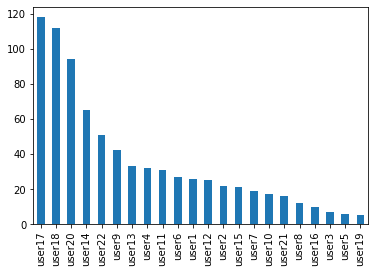

In [298]:
y_train['label'].value_counts().plot.bar()

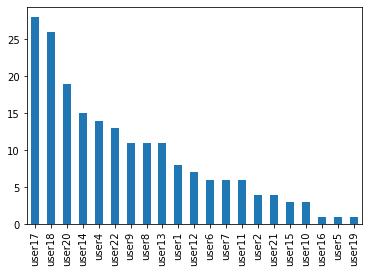

In [299]:
y_test['label'].value_counts().plot.bar()

In [303]:
df['avg_ac_mag'].describe()

count    989.000000
mean       9.966918
std        0.464799
min        8.393484
25%        9.768922
50%        9.908599
75%       10.057321
max       13.676693
Name: avg_ac_mag, dtype: float64

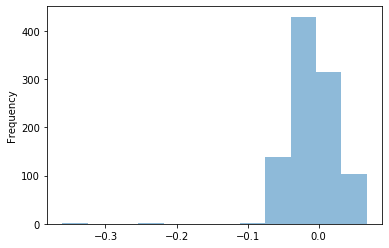

In [304]:
#df['atcr_avg_ac_mag'].value_counts().plot.bar()
ax = df['atcr_avg_ac_mag'].plot.hist(bins=12, alpha=0.5)

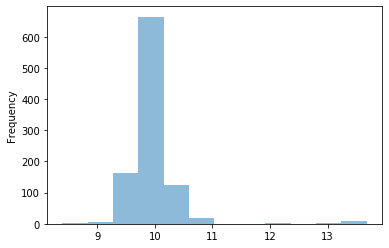

In [305]:
ax = df['avg_ac_mag'].plot.hist(bins=12, alpha=0.5)

In [ ]:
ax = df['avg_ac_mag'].plot.hist(bins=12, alpha=0.5)

# Modelling

In [414]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5,dual = True,max_iter=10000)
clf.fit(X_train, y_train.values.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [415]:
y_test["label"].unique().tolist()

['user1',
 'user2',
 'user4',
 'user5',
 'user6',
 'user7',
 'user8',
 'user9',
 'user10',
 'user11',
 'user12',
 'user13',
 'user14',
 'user15',
 'user16',
 'user17',
 'user18',
 'user19',
 'user20',
 'user21',
 'user22']

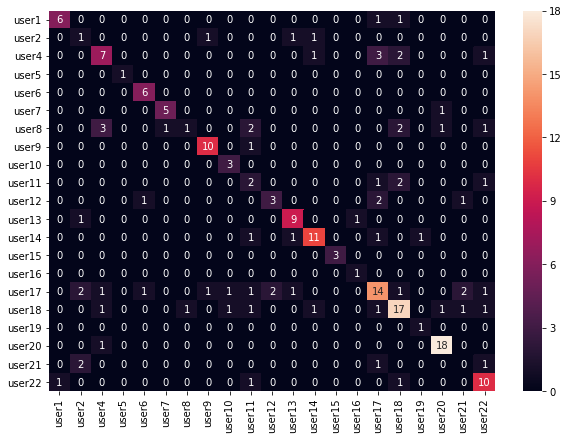

In [416]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
pred = clf.predict(X_test)
cm=confusion_matrix(y_test.values.ravel(),pred,labels=y_test["label"].unique().tolist())
df_cm = pd.DataFrame(cm, index = [i for i in y_test["label"].unique().tolist()],
                  columns = [i for i in y_test["label"].unique().tolist()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


In [417]:
from sklearn.metrics import classification_report
print(classification_report(y_test.values.ravel(),pred))

              precision    recall  f1-score   support

       user1       0.86      0.75      0.80         8
      user10       0.60      1.00      0.75         3
      user11       0.22      0.33      0.27         6
      user12       0.60      0.43      0.50         7
      user13       0.75      0.82      0.78        11
      user14       0.79      0.73      0.76        15
      user15       1.00      1.00      1.00         3
      user16       0.50      1.00      0.67         1
      user17       0.58      0.50      0.54        28
      user18       0.65      0.65      0.65        26
      user19       0.50      1.00      0.67         1
       user2       0.17      0.25      0.20         4
      user20       0.86      0.95      0.90        19
      user21       0.00      0.00      0.00         4
      user22       0.62      0.77      0.69        13
       user4       0.54      0.50      0.52        14
       user5       1.00      1.00      1.00         1
       user6       0.75    

In [347]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [379]:
from sklearn.metrics import classification_report
pred = clf.predict(X_train)
print(classification_report(y_train.values.ravel(),pred))

              precision    recall  f1-score   support

       user1       1.00      1.00      1.00        26
      user10       1.00      1.00      1.00        17
      user11       1.00      1.00      1.00        31
      user12       1.00      1.00      1.00        25
      user13       1.00      1.00      1.00        33
      user14       1.00      1.00      1.00        65
      user15       1.00      1.00      1.00        21
      user16       1.00      1.00      1.00        10
      user17       1.00      1.00      1.00       118
      user18       1.00      1.00      1.00       112
      user19       1.00      1.00      1.00         5
       user2       1.00      1.00      1.00        22
      user20       1.00      1.00      1.00        94
      user21       1.00      1.00      1.00        16
      user22       1.00      1.00      1.00        51
       user3       1.00      1.00      1.00         7
       user4       1.00      1.00      1.00        32
       user5       1.00    

In [349]:
from sklearn.metrics import classification_report
pred = clf.predict(X_test)
print(classification_report(y_test.values.ravel(),pred))

              precision    recall  f1-score   support

       user1       0.86      0.75      0.80         8
      user10       1.00      0.67      0.80         3
      user11       0.62      0.83      0.71         6
      user12       1.00      0.86      0.92         7
      user13       0.90      0.82      0.86        11
      user14       0.92      0.73      0.81        15
      user15       1.00      0.67      0.80         3
      user16       0.00      0.00      0.00         1
      user17       0.61      0.82      0.70        28
      user18       0.58      0.81      0.68        26
      user19       1.00      1.00      1.00         1
       user2       0.29      0.50      0.36         4
      user20       0.89      0.89      0.89        19
      user21       0.33      0.25      0.29         4
      user22       0.92      0.85      0.88        13
       user3       0.00      0.00      0.00         0
       user4       0.90      0.64      0.75        14
       user5       1.00    

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



# Explainability and Removing Overfitting

In [362]:
l=df.columns.values.tolist()
l.remove("label")

15 37
Feature ranking:
avg_x 0.06416495569606878
avg_z 0.05764411650811791
min_x 0.05218824058353637
avg_y 0.04827756007507986
max_z 0.040277234509638715
max_x 0.03778131793107463
min_z 0.03752821769838998
var_x 0.03649943969699985
var_ac_mag 0.034103818736053844
max_y 0.03405975348910767
min_y 0.03168089853224414
var_y 0.03140066863280132
avg_ac_mag 0.031095456866970933
max_ac_mag 0.03084533428374873
min_ac_mag 0.02634330262805751


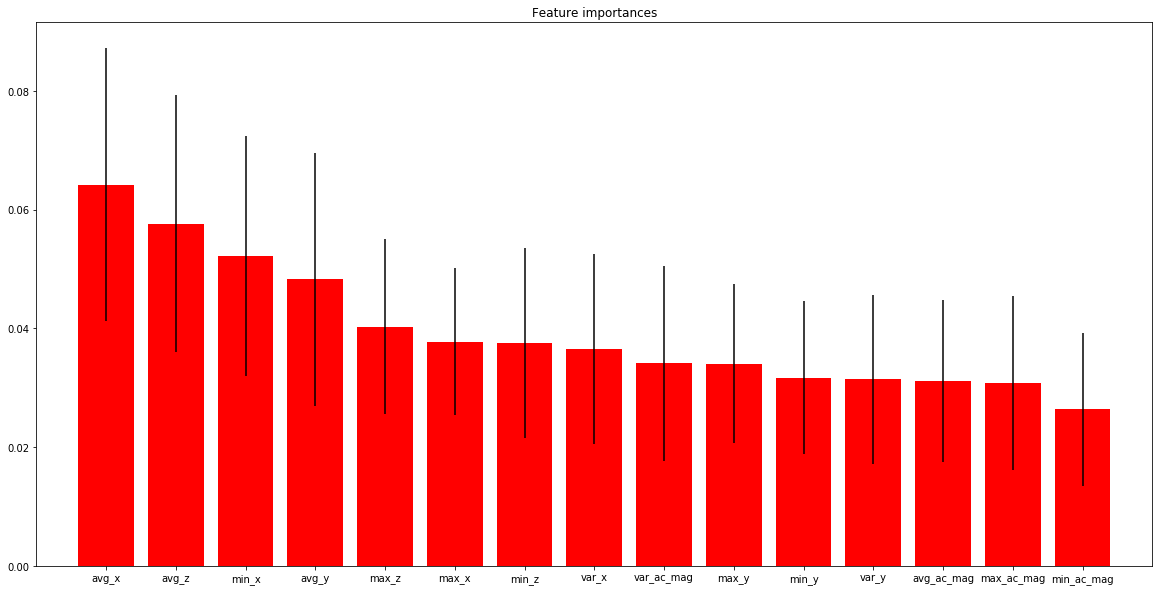

In [378]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10


# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:15]
print(len(indices),len(l))

# Print the feature ranking
print("Feature ranking:")

ordered_f=[]
for f in range(len(indices)):
    print( l[indices[f]], importances[indices[f]])
    ordered_f.append(l[indices[f]])

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances[indices])), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances[indices])), ordered_f)
plt.xlim([-1, len(importances[indices])])
plt.show()

In [387]:
from sklearn import feature_selection

In [398]:
feature_selection.mutual_info_classif(X_train, y_train.values.ravel())

array([0.21111941, 0.1482932 , 0.19730593, 0.14604883, 0.06564551,
       0.06997049, 0.05883067, 0.10487425, 0.30283552, 0.1439517 ,
       0.21790947, 0.05285333, 0.22196938, 0.25152755, 0.24470704,
       0.18950368, 0.4437443 , 0.19675366, 1.16937706, 0.87984897,
       0.84846342, 0.46456031, 0.59231077, 0.42101852, 0.52343642,
       0.3591118 , 0.79390422, 0.48491008, 0.54106703, 0.07647477,
       0.1513913 , 0.105875  , 0.18355227, 0.49929698, 0.62052881,
       0.46169305, 0.31535552])

In [399]:
train.loc[ : , train.columns != 'label'].corr()

,atcr_avg_ac_mag,atcr_avg_x,atcr_avg_y,atcr_avg_z,atcr_max_ac_mag,atcr_max_x,atcr_max_y,atcr_max_z,atcr_min_ac_mag,atcr_min_x,...,min_y,min_z,num_fluct_ac_mag,num_fluct_x,num_fluct_y,num_fluct_z,var_ac_mag,var_x,var_y,var_z
atcr_avg_ac_mag,1.000000,0.170740,0.370160,0.212769,-0.024925,0.026051,-0.038328,-0.042425,0.200317,0.020170,...,-0.181949,-0.043730,0.159494,0.010762,0.163445,0.110107,0.165669,0.136317,0.187659,0.034796
atcr_avg_x,0.170740,1.000000,0.145251,0.098282,0.015620,0.266791,0.020141,0.018085,0.017467,0.444898,...,0.049177,0.081055,0.040299,-0.011294,0.028933,0.028302,-0.002013,-0.023309,-0.061265,-0.110019
atcr_avg_y,0.370160,0.145251,1.000000,0.420467,0.100617,0.119405,0.297478,0.176478,-0.029936,0.059379,...,0.072732,-0.044076,-0.035637,0.060550,0.157277,0.091820,0.156709,0.095481,0.023351,-0.195345
atcr_avg_z,0.212769,0.098282,0.420467,1.000000,0.066742,0.120585,0.193209,0.344850,-0.017900,-0.026876,...,-0.037154,-0.030277,0.014596,0.021890,-0.013466,0.059038,0.090773,0.115179,0.056255,-0.034881
atcr_max_ac_mag,-0.024925,0.015620,0.100617,0.066742,1.000000,0.779327,0.930256,0.782537,-0.795563,-0.162741,...,-0.009572,-0.278221,-0.581291,0.118606,-0.364606,-0.044387,0.464662,0.102498,0.388476,-0.187886
atcr_max_x,0.026051,0.266791,0.119405,0.120585,0.779327,1.000000,0.762055,0.713380,-0.577438,-0.110535,...,-0.000251,-0.189447,-0.445931,-0.029145,-0.286672,0.017243,0.413866,0.140398,0.319716,-0.184398
atcr_max_y,-0.038328,0.020141,0.297478,0.193209,0.930256,0.762055,1.000000,0.809415,-0.746940,-0.153465,...,0.046455,-0.264833,-0.546370,0.136799,-0.325697,-0.019646,0.454149,0.109347,0.356729,-0.228740
atcr_max_z,-0.042425,0.018085,0.176478,0.344850,0.782537,0.713380,0.809415,1.000000,-0.584684,-0.111064,...,0.041866,-0.161294,-0.443726,0.110048,-0.304637,-0.094753,0.366866,0.084497,0.296144,-0.170310
atcr_min_ac_mag,0.200317,0.017467,-0.029936,-0.017900,-0.795563,-0.577438,-0.746940,-0.584684,1.000000,0.158424,...,0.004420,0.256505,0.509235,-0.097292,0.314240,0.004198,-0.366101,0.000478,-0.308964,0.146973
atcr_min_x,0.020170,0.444898,0.059379,-0.026876,-0.162741,-0.110535,-0.153465,-0.111064,0.158424,1.000000,...,0.094259,-0.011673,0.107124,0.085425,0.081234,-0.087535,-0.144856,-0.168468,-0.132368,-0.056646
